### Problem Statement 1:

A retail store that has multiple outlets across the country are facing issues in managing the
inventory - to match the demand with respect to supply. You are a data scientist, who has to
come up with useful insights using the data and make prediction models to forecast the sales for
X number of months/years.

In [ ]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 8.5 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
from pmdarima import auto_arima
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from pandas.tseries.offsets import DateOffset
from matplotlib import pyplot
from statistics import mean
import warnings

warnings.filterwarnings("ignore")

Creating useful Functions

In [ ]:
def get_graphs(k):
  col1,col2,col3,col4,col5=([] for i in range(5))
  ndata = dataset[dataset['Store']==k].copy()
  ndata.reset_index(inplace=True)
  scaler = MinMaxScaler()
  hol_ndata=ndata.copy()
  ndata['Weekly_Sales'] = scaler.fit_transform(ndata[['Weekly_Sales']])
  hol_ndata['Weekly_Sales'] = scaler.fit_transform(hol_ndata[['Weekly_Sales']])
  #ndata['Temperature'] = scaler.fit_transform(ndata[['Temperature']])
  ndata['Temperature'] = ndata['Temperature'].astype(int)
  ndata["Date_monthly"] = pd.to_datetime(ndata["Date"]).dt.strftime('%Y %b')
  ndata.drop(['Store','Date' ,'Holiday_Flag','CPI'],axis=1,inplace=True)
  hol_ndata.drop(['Store','Fuel_Price','CPI','Unemployment','Temperature'],axis=1,inplace=True)
  monthly_ndata = ndata.groupby(['Date_monthly']).mean()
  monthly_ndata=monthly_ndata.reset_index()
  monthly_ndata['Datesub'] = pd.to_datetime(monthly_ndata['Date_monthly'])
  monthly_ndata=monthly_ndata.sort_values(by=['Datesub'],ascending = True)
  monthly_ndata.reset_index(drop=True,inplace=True)
  #part 2
  fig,axes = plt.subplots(2,figsize= (10,4))
  sns.lineplot( x=hol_ndata['Date'], y=hol_ndata[hol_ndata['Holiday_Flag'] == 1]['Weekly_Sales'],label='Holiday',ax=axes[0])
  sns.lineplot( x=hol_ndata['Date'], y=hol_ndata[hol_ndata['Holiday_Flag'] == 0]['Weekly_Sales'], label='No Holiday',ax=axes[0])
  axes[0].set_ylabel(f'Weekly Sales')
  axes[0].set_title(f'Graphs for Insights in Store {k}')
  axes[0].legend(loc='best')
  #plt.show()
  # part 3
  #fig,axes = plt.subplots(2,sharex=True,figsize= (10,4))
  #plt.xticks(rotation=90)
 # sns.barplot( x=monthly_ndata['Date_monthly'], y=monthly_ndata['Temperature'], ax=axes[0])
  #sns.barplot( x=monthly_ndata['Date_monthly'], y=monthly_ndata['Weekly_Sales'],ax=axes[1])

  #part4
  bin_edge = np.histogram_bin_edges(ndata['Temperature'], bins=5, range=None)
  bin_gap = (max(ndata['Temperature']) -min(ndata['Temperature']))/5
  bin_ranges =[ f'{i} - {(i+bin_gap):.1f}' for i in bin_edge]
  #print(bin_ranges)
  #print(ndata['Weekly_Sales'][:5])
  for k,i in enumerate(ndata['Temperature']):
    #print(k,i,ndata['Weekly_Sales'][k])
    if ((i >= bin_edge[0]) and (i < bin_edge[1])):
      col1.append(ndata['Weekly_Sales'][k])
    elif ((i >= bin_edge[1]) and( i < bin_edge[2])):
      col2.append(ndata['Weekly_Sales'][k])
    elif ((i >= bin_edge[2]) and(i < bin_edge[3])):
      col3.append(ndata['Weekly_Sales'][k])
    elif ((i >= bin_edge[3]) and(i < bin_edge[4])):
      col4.append(ndata['Weekly_Sales'][k])
    elif (i >= bin_edge[4]) :
      col5.append(ndata['Weekly_Sales'][k])

  print(len(col1), len(col2), len(col3), len(col4), len(col5))
  temp_data_bar=pd.DataFrame([{bin_ranges[0]:mean(col1),bin_ranges[1]:mean(col2),bin_ranges[2]:mean(col3),bin_ranges[3]:mean(col4),bin_ranges[4]:mean(col5)}])
  sns.barplot(temp_data_bar,ax=axes[1])
  #sns.histplot( x=ndata['Temperature'], y=ndata['Weekly_Sales'],bins=5)
  axes[1].set_xlabel('Temperature Ranges')
  axes[1].set_ylabel('Avg Weekly Sales')
  #plt.xticks(rotation=90)
  plt.show()

In [ ]:


# H0 : It is non-stationary
# H1 : It is Stationary

def adfuller_test(data):
  print(' H0 : It is non-stationary')
  print(' H1 : It is Stationary')
  result=adfuller(data)
  labels=['ADF Test Statistic', 'p-value', 'Lags Used', 'Numer of Observations Used']
  for v,l in zip(result,labels):
    print(l+' : '+str(v))
  for key, value in result[4].items():
      print('\t%s: %.3f' %(key, value))
  if result[1] <= 0.05:
    print("Strong evidence against Null Hypothesis. Reject Null Hypothesis")
  else:
    print("Weak evidence against Null Hypothesis. Accept Null Hypothesis")

  #Null hypothesis (H0): The data is stationary.
#Alternate hypothesis (H1): The data is not stationary.

def kpss_test(data):
  print(' H0 : It is stationary')
  print(' H1 : It is  non-stationary')
  result_kpss_ct=kpss(data,regression="ct")
  print('Test Statistic: %f' %result_kpss_ct[0])
  print('p-value: %f' %result_kpss_ct[1])
  print('Critical values:')
  for key, value in result_kpss_ct[3].items():
      print('\t%s: %.3f' %(key, value))


In [ ]:
def error_cal(test_data, forecast_data,typeofmodel):
  mae= mean_absolute_error(test_data,forecast_data )
  mape=mean_absolute_percentage_error(test_data,forecast_data )
  rmse=np.sqrt(mean_squared_error(test_data,forecast_data ))
  print(f"mae - {typeofmodel} : {mae}")
  print(f"mape - {typeofmodel} : {mape}")
  print(f"rmse - {typeofmodel} : {rmse}")
  print("\n")

In [ ]:
dataset= pd.read_csv('Walmart.xls')
dataset.head()

Store        Date  Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price  \
0      1  05-02-2010    1643690.90             0        42.31       2.572   
1      1  12-02-2010    1641957.44             1        38.51       2.548   
2      1  19-02-2010    1611968.17             0        39.93       2.514   
3      1  26-02-2010    1409727.59             0        46.63       2.561   
4      1  05-03-2010    1554806.68             0        46.50       2.625   

          CPI  Unemployment  
0  211.096358         8.106  
1  211.242170         8.106  
2  211.289143         8.106  
3  211.319643         8.106  
4  211.350143         8.106

In [ ]:
dataset.shape

(6435, 8)

Dataset has 6435 rows and 8 columns/Features

In [ ]:
dataset.columns

Index(['Store', 'Date', 'Weekly_Sales', 'Holiday_Flag', 'Temperature',
       'Fuel_Price', 'CPI', 'Unemployment'],
      dtype='object')

In [ ]:
dataset.Store.nunique()

45

There are 45 stores.

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB


Here Date is in Object datatype. Converting it to Datetime format.

In [ ]:
dataset['Date'].head()

0    05-02-2010
1    12-02-2010
2    19-02-2010
3    26-02-2010
4    05-03-2010
Name: Date, dtype: object

In [ ]:
dataset['Date'] =pd.to_datetime(dataset['Date'], dayfirst=True)

In [ ]:
dataset.describe()

Store  Weekly_Sales  Holiday_Flag  Temperature   Fuel_Price  \
count  6435.000000  6.435000e+03   6435.000000  6435.000000  6435.000000   
mean     23.000000  1.046965e+06      0.069930    60.663782     3.358607   
std      12.988182  5.643666e+05      0.255049    18.444933     0.459020   
min       1.000000  2.099862e+05      0.000000    -2.060000     2.472000   
25%      12.000000  5.533501e+05      0.000000    47.460000     2.933000   
50%      23.000000  9.607460e+05      0.000000    62.670000     3.445000   
75%      34.000000  1.420159e+06      0.000000    74.940000     3.735000   
max      45.000000  3.818686e+06      1.000000   100.140000     4.468000   

               CPI  Unemployment  
count  6435.000000   6435.000000  
mean    171.578394      7.999151  
std      39.356712      1.875885  
min     126.064000      3.879000  
25%     131.735000      6.891000  
50%     182.616521      7.874000  
75%     212.743293      8.622000  
max     227.232807     14.313000

In [ ]:
dataset['Holiday_Flag'].value_counts()

0    5985
1     450
Name: Holiday_Flag, dtype: int64

## **Data Cleaning**

Checking for duplicates rows

In [ ]:
dataset.duplicated().sum()

0

Checking for Null Values

In [ ]:
dataset.isnull().sum()

Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64

Checking for outliers.




In [ ]:
par = {'axes.titlesize':7}
plt.rcParams.update(par)

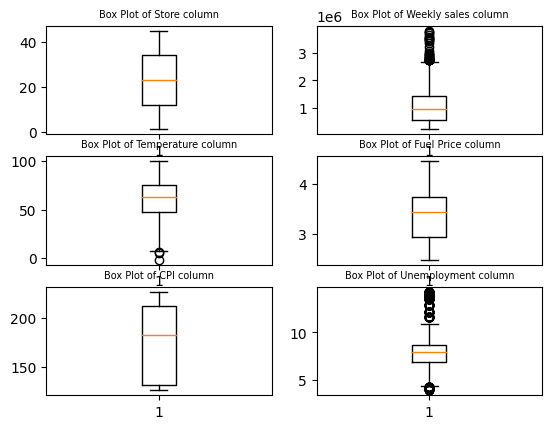

In [ ]:
figure, axis = plt.subplots(3, 2)
axis[0,0].boxplot(dataset['Store'])
axis[0,0].set_title('Box Plot of Store column')
axis[0,1].boxplot(dataset['Weekly_Sales'])
axis[0,1].set_title('Box Plot of Weekly sales column')
axis[1,0].boxplot(dataset['Temperature'])
axis[1,0].set_title('Box Plot of Temperature column')
axis[1,1].boxplot(dataset['Fuel_Price'])
axis[1,1].set_title('Box Plot of Fuel Price column')
axis[2,0].boxplot(dataset['CPI'])
axis[2,0].set_title('Box Plot of CPI column')
axis[2,1].boxplot(dataset['Unemployment'])
axis[2,1].set_title('Box Plot of Unemployment column')
plt.show()

As seen Temperature, Weekly_sales and Unemployement has outliers. When taken entire dataset for consideration with 45 stores.

## **EDA**

Heatmap for 4 random stores

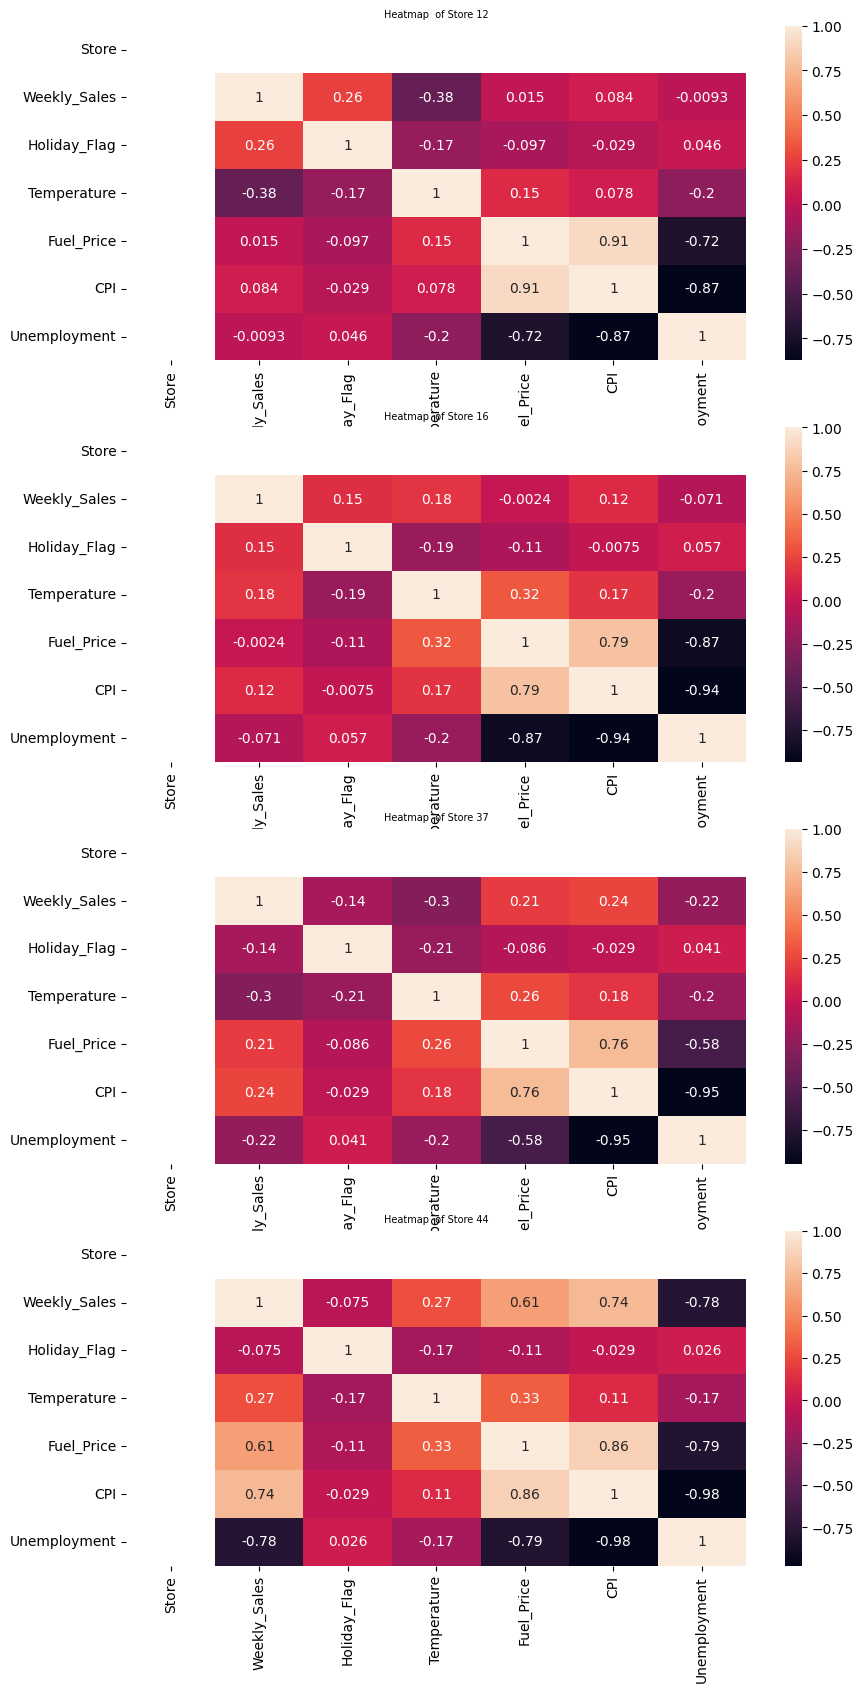

In [ ]:
store_for_heatmap=np.random.choice(dataset.Store.unique(),4)
dataset_for_heatmap =dataset.drop(columns = ['Date'])
figure, axis = plt.subplots(4, figsize=(10,20))
for i,k in enumerate(store_for_heatmap):
  sns.heatmap(dataset_for_heatmap[dataset_for_heatmap['Store']==k].corr(),annot=True, ax= axis[i])
  axis[i].set_title(f'Heatmap  of Store {k}')
plt.show()

 Correlation of Target w.r.t to indenpendant columns based on each store

In [ ]:
store_list = list(dataset.Store.unique())
col=list(dataset.columns)

In [ ]:
col.remove('Date')

In [ ]:
# correaltion of Target wrt to indenpendant columns based on each store
df_storewise_corr=pd.DataFrame(columns=col)
for i in store_list:
  df_temp_store_data = dataset[dataset['Store'] == i ]
  val = df_temp_store_data.corr()['Weekly_Sales'].to_list()
  val[0]="Store_"+str(i)
  df_storewise_corr.loc[len(df_storewise_corr.index)] =val
df_storewise_corr.drop("Weekly_Sales",axis=1, inplace=True)
df_storewise_corr.set_index("Store", inplace=True)

In [ ]:
df_storewise_corr.head()

Holiday_Flag  Temperature  Fuel_Price       CPI  Unemployment
Store                                                                 
Store_1      0.194905    -0.222701    0.124592  0.225408     -0.097955
Store_2      0.177726    -0.297673   -0.196375 -0.062431      0.066325
Store_3      0.208556    -0.377524    0.140886  0.317250     -0.230413
Store_4      0.153388    -0.225583    0.211549  0.351157     -0.337015
Store_5      0.302525    -0.175517    0.167352  0.308261     -0.207043

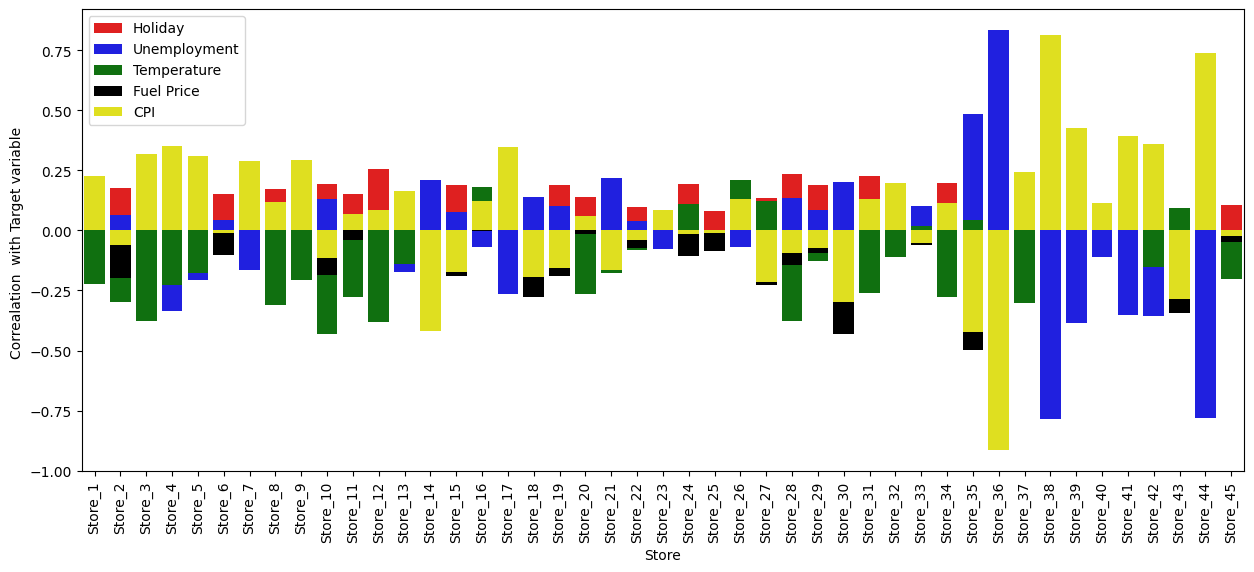

In [ ]:
fig,axes = plt.subplots(figsize= (15,6))
plt.xticks(rotation=90)
sns.barplot(x=df_storewise_corr.index, y=df_storewise_corr.Holiday_Flag, color= 'Red', label = 'Holiday')
sns.barplot(x=df_storewise_corr.index, y=df_storewise_corr.Unemployment, color= 'Blue', label = 'Unemployment')
sns.barplot(x=df_storewise_corr.index, y=df_storewise_corr.Temperature, color= 'Green', label = 'Temperature')
sns.barplot(x=df_storewise_corr.index, y=df_storewise_corr.Fuel_Price, color= 'black', label = 'Fuel Price')
sns.barplot(x=df_storewise_corr.index, y=df_storewise_corr.CPI, color= 'Yellow', label = 'CPI')
plt.ylabel('Correalation  with Target variable ')
plt.legend(loc='best')
plt.show()

Some stores are affected greatly by unemployement, while some affected by Fuel price. This type of fluctuating data will be very hard to build a general model for all stores.

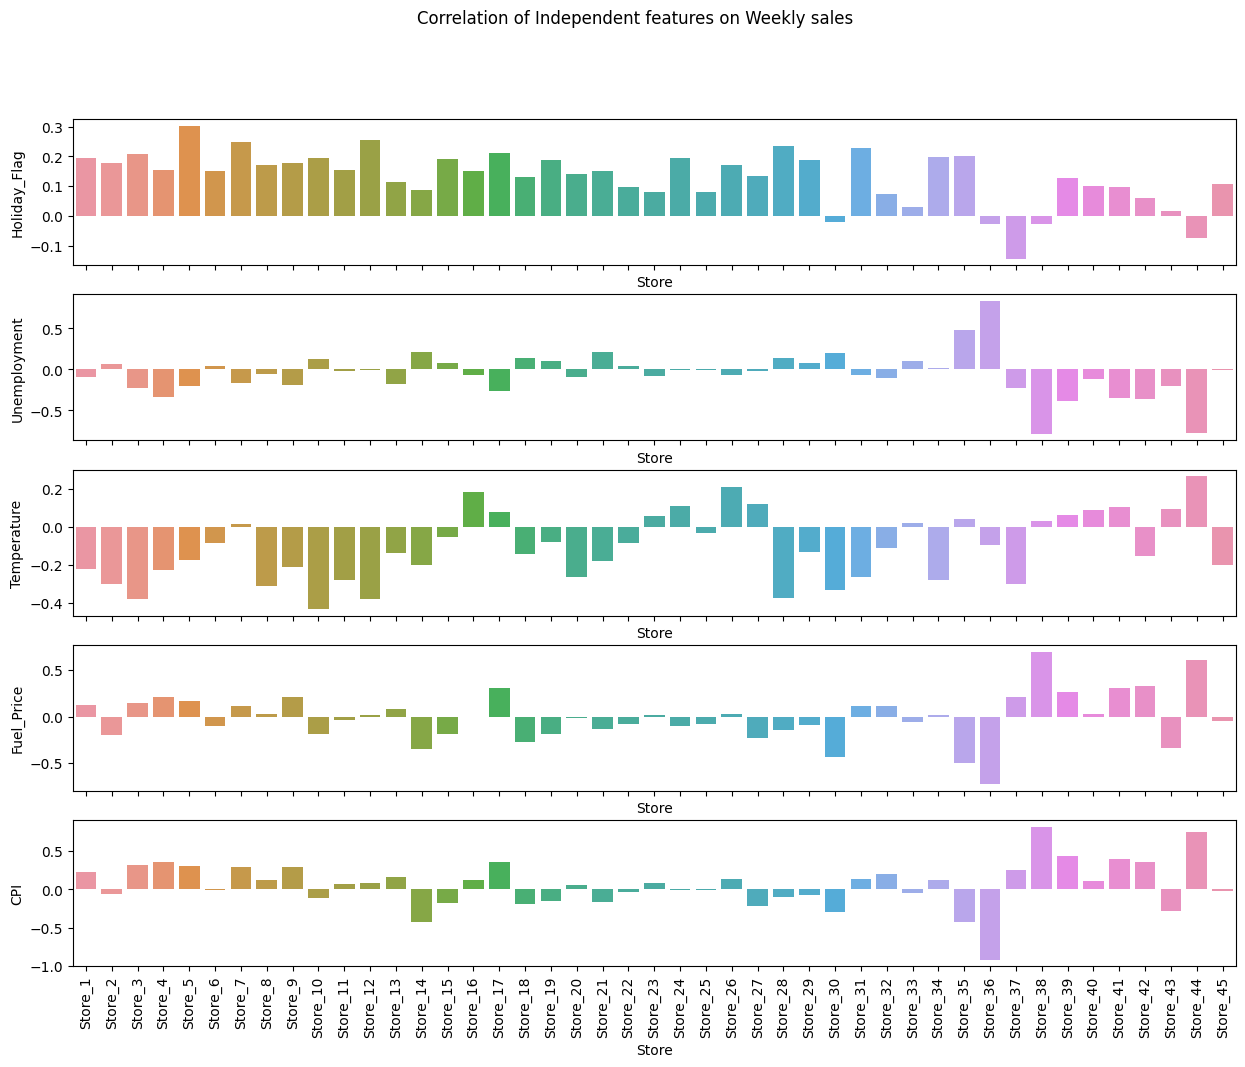

In [ ]:
fig,axes = plt.subplots(5,figsize= (15,11),sharex=True)
plt.xticks(rotation=90)
fig.suptitle('Correlation of Independent features on Weekly sales')
sns.barplot(x=df_storewise_corr.index, y=df_storewise_corr.Holiday_Flag, label = 'Holiday', ax= axes[0])
sns.barplot(x=df_storewise_corr.index, y=df_storewise_corr.Unemployment, label = 'Holiday', ax= axes[1])
sns.barplot(x=df_storewise_corr.index, y=df_storewise_corr.Temperature, label = 'Holiday', ax= axes[2])
sns.barplot(x=df_storewise_corr.index, y=df_storewise_corr.Fuel_Price, label = 'Holiday', ax= axes[3])
sns.barplot(x=df_storewise_corr.index, y=df_storewise_corr.CPI, label = 'Holiday', ax= axes[4])
plt.show()

A. Useful insights that can be used by each of
the stores to improve in various areas.

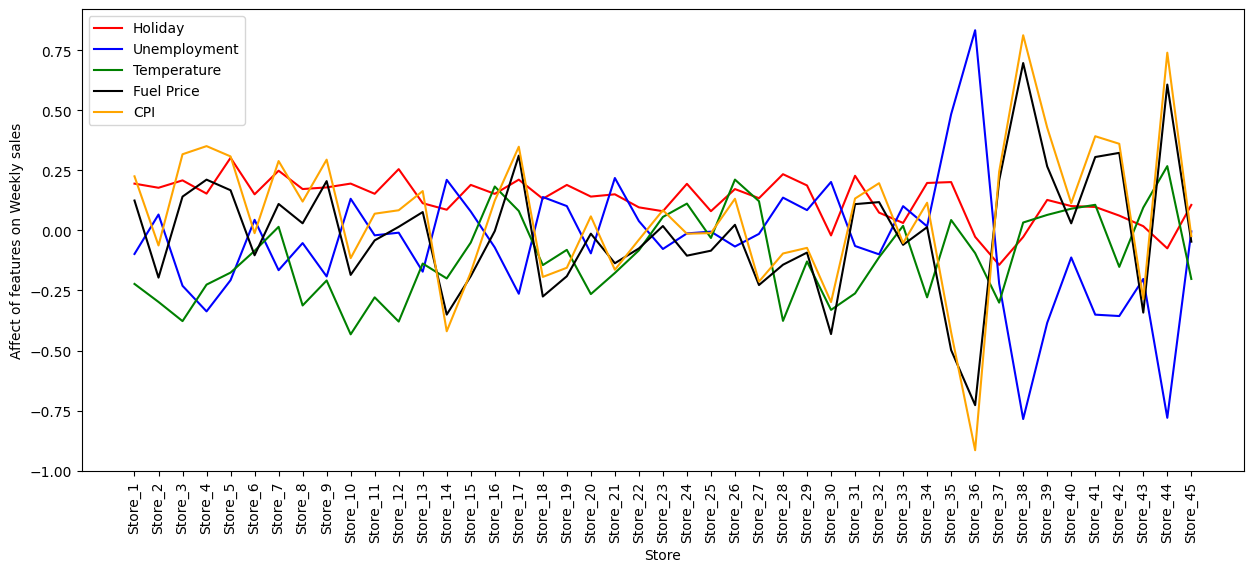

In [ ]:
fig,axes = plt.subplots(figsize= (15,6))
plt.xticks(rotation=90)
sns.lineplot(x=df_storewise_corr.index, y=df_storewise_corr.Holiday_Flag, color= 'Red', label = 'Holiday')
sns.lineplot(x=df_storewise_corr.index, y=df_storewise_corr.Unemployment, color= 'Blue', label = 'Unemployment')
sns.lineplot(x=df_storewise_corr.index, y=df_storewise_corr.Temperature, color= 'Green', label = 'Temperature')
sns.lineplot(x=df_storewise_corr.index, y=df_storewise_corr.Fuel_Price, color= 'black', label = 'Fuel Price')
sns.lineplot(x=df_storewise_corr.index, y=df_storewise_corr.CPI, color= 'Orange', label = 'CPI')
plt.legend(loc='best')
plt.ylabel('Affect of features on Weekly sales')
plt.show()

As seen in above graph, only 4 features namely had good correlation(Threshold > +/- 0.2 ) for some of the stores. The 4 features are Unemployement, Fuel Price, CPI and Temperature.Also CPI was observed to be closely following Fuel price which inidcates same effect on the weekly sales by both the features.But both these are uncontrollable factor so cannot be taken into consideration for impoving sales.<br> So 2 features i,e Temperature and Holiday will taken into consideration for insights in each store.

<br>Tool for Graphs for each store <br>

In [ ]:

k=int( input("Insert Store No to get the Graphs: "))
if(k > 45) or (k<1):
  print("Store No out of range")
else:
  get_graphs(k)

In [ ]:
  get_graphs(21)

In [ ]:
  get_graphs(22)

11 27 24 37 44


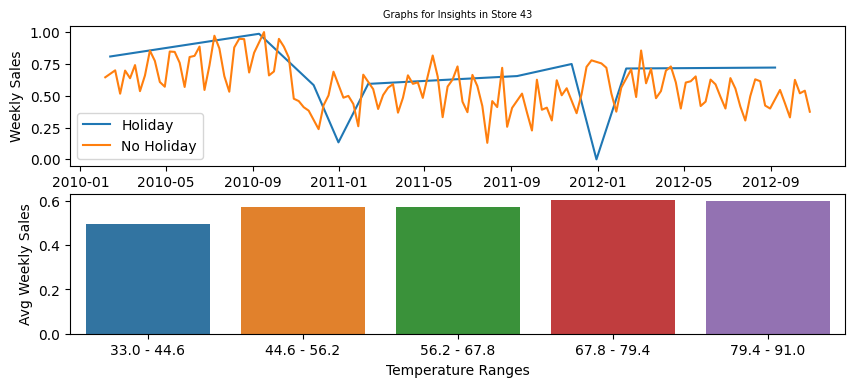

In [ ]:
  get_graphs(23)

11 39 33 27 33


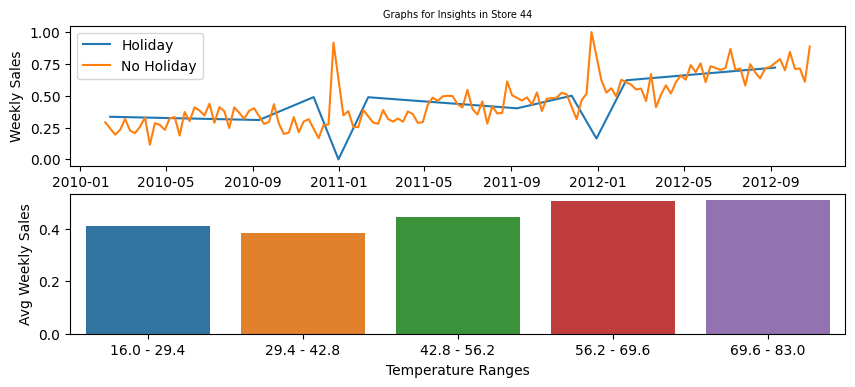

In [ ]:
  get_graphs(24)

17 27 28 31 40


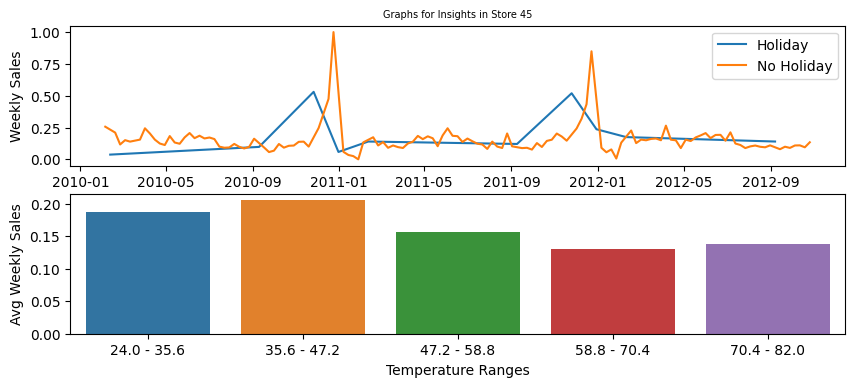

In [ ]:
  get_graphs(25)

In [ ]:
  get_graphs(26)

In [ ]:
  get_graphs(27)

In [ ]:
  get_graphs(18)

In [ ]:
  get_graphs(19)

In [ ]:
  get_graphs(20)


B. Forecast the sales for each store for the next 12 weeks.

From this we can see 4 features Holiday, unemployement, Temperature ,Fuel price varies differently for different stores. Hence we cannot user entire data as a whole for forecasting. Forecasting will be done for indivisual store data. Here in this case, Top 5 stores will be taken with highest weekly sales.

Top 3 Stores with highest weekly sales.

In [ ]:
wsd = dataset.groupby('Store')['Weekly_Sales'].sum().sort_values(ascending = True)
wsd.head(3)

Store
33    37160221.96
44    43293087.84
5     45475688.90
Name: Weekly_Sales, dtype: float64

Top 3 Stores with  lowest weekly sales.

In [ ]:
wsa = dataset.groupby('Store')['Weekly_Sales'].sum().sort_values(ascending = False)
wsa.head(3)

Store
20    3.013978e+08
4     2.995440e+08
14    2.889999e+08
Name: Weekly_Sales, dtype: float64

### Building Model using  ARIMA and SARIMA Storewise

For Store 33

In [ ]:
model_data=dataset.copy()
sn=33 #store number
model_data = model_data.loc[dataset['Store']==sn,['Date','Weekly_Sales']]
model_data.set_index('Date',inplace=True)
model_data.tail()

Weekly_Sales
Date                    
2012-09-28     242813.51
2012-10-05     265444.90
2012-10-12     291781.15
2012-10-19     254412.34
2012-10-26     253731.13

In [ ]:
model_data.dtypes

Weekly_Sales    float64
dtype: object

In [ ]:
model_data.shape

(143, 1)

<Axes: xlabel='Date'>

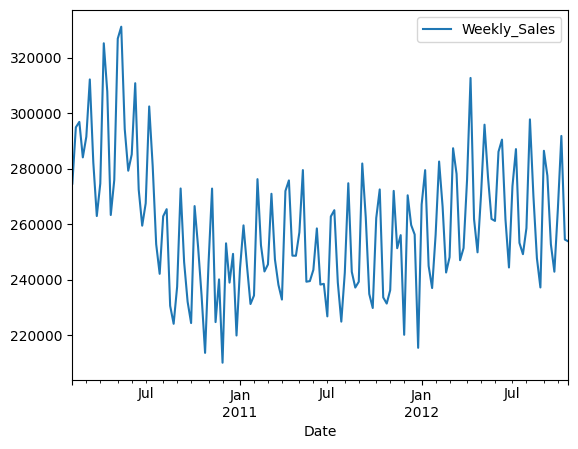

In [ ]:
model_data.plot()

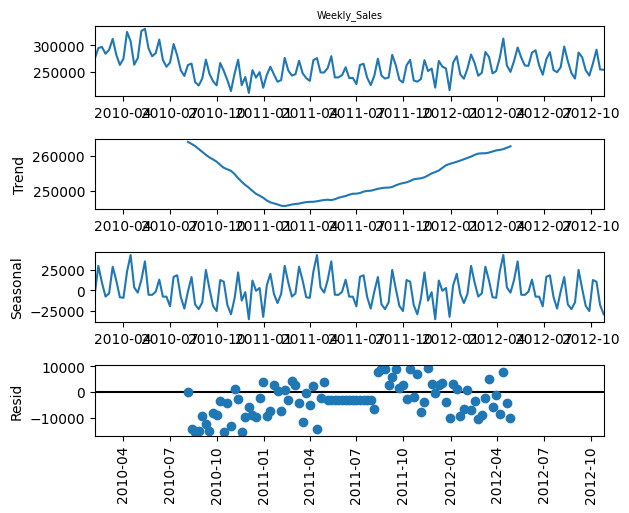

In [ ]:

result = seasonal_decompose(model_data['Weekly_Sales'], model='additive')
result.plot()
plt.xticks(rotation=90)
plt.show()

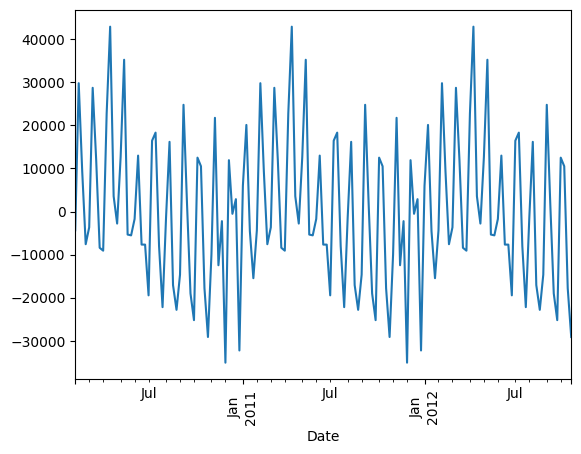

In [ ]:
result.seasonal.plot()
plt.xticks(rotation=90)
plt.show()

Shows seasonality yearly

ADF Stationarity Test and KPSS Stationarity Test

In [ ]:
adfuller_test(model_data['Weekly_Sales'])

 H0 : It is non-stationary
 H1 : It is Stationary
ADF Test Statistic : -4.1378733255323015
p-value : 0.0008379552269735709
Lags Used : 14
Numer of Observations Used : 128
	1%: -3.483
	5%: -2.884
	10%: -2.579
Strong evidence against Null Hypothesis. Reject Null Hypothesis


In [ ]:
kpss_test(model_data['Weekly_Sales'])

 H0 : It is stationary
 H1 : It is  non-stationary
Test Statistic: 0.347733
p-value: 0.010000
Critical values:
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216


For store 33, weekly sales timeseries ADF concludes stationary, and KPSS concludes non-stationary – The series is difference stationary.

Differencing to make it stationary

In [ ]:
model_data['seasonal_first_difference']= model_data['Weekly_Sales']-model_data['Weekly_Sales'].shift(4)

In [ ]:
adfuller_test(model_data['seasonal_first_difference'].dropna())

 H0 : It is non-stationary
 H1 : It is Stationary
ADF Test Statistic : -2.931721538033899
p-value : 0.04178161631316069
Lags Used : 13
Numer of Observations Used : 125
	1%: -3.484
	5%: -2.885
	10%: -2.579
Strong evidence against Null Hypothesis. Reject Null Hypothesis


In [ ]:
kpss_test(model_data['seasonal_first_difference'].dropna())

 H0 : It is stationary
 H1 : It is  non-stationary
Test Statistic: 0.068064
p-value: 0.100000
Critical values:
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216


<Axes: xlabel='Date'>

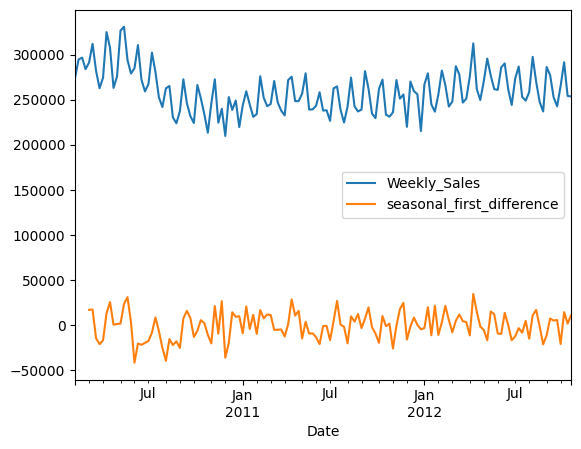

In [ ]:
model_data.plot()

Now the Timeseries is Stationary.

Manually selecting p,d,q values using charts

## Plotting ACF and PACF Plots

*   **Identification of AR Model is often done best with PACF.**
    <br><br>For an AR model, theoretical PACF shuts off  past the order of the model. The phrase shuts off  means that in theory the Partial autocorrelation are to 0 beyond that point.<br><br>
*   **Identification of MA Model is often done best with ACF rather than PACF.**
<br><br>For a MA model, theoritical PACF does not shuts off but instead tapers towards 0. The ACF  will have non-zero auto-correlations only at lags involved in the model.



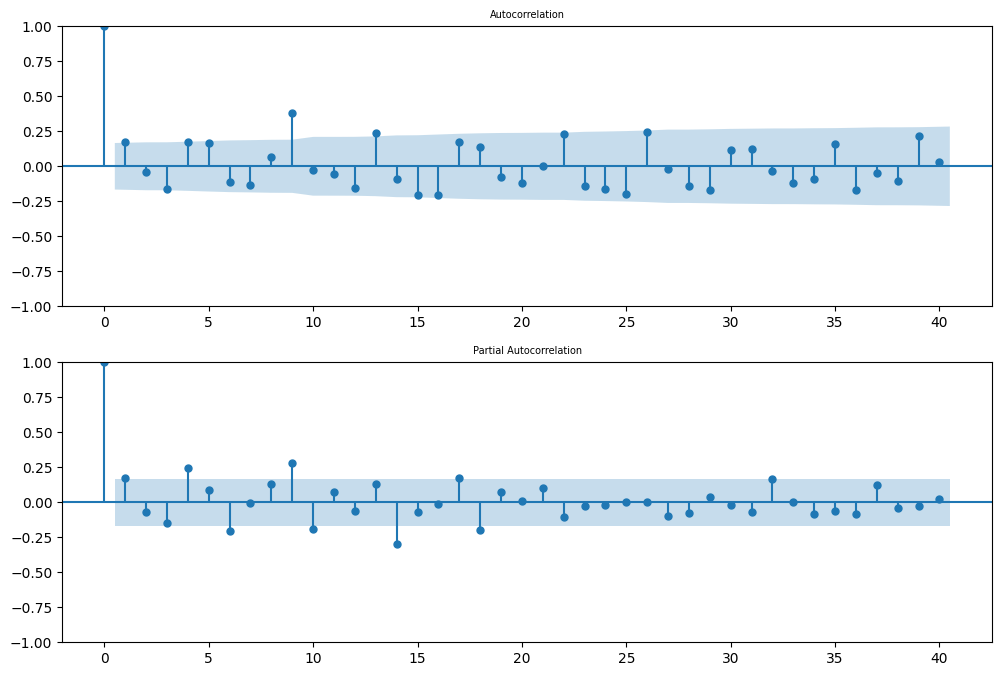

In [ ]:
fig=plt.figure(figsize=(12,8))
ax1= fig.add_subplot(211)
fig= sm.graphics.tsa.plot_acf(model_data['seasonal_first_difference'].dropna(), lags=40,ax=ax1)
ax2= fig.add_subplot(212)
fig= sm.graphics.tsa.plot_pacf(model_data['seasonal_first_difference'].dropna(), lags=40,ax=ax2)


P =  1/4 <br>
D = 1 <br>
Q = 1/4/9 <br>

Using Auto arima for Optimal p,d,q values based on  AIC Criterion

Using without stepwise

In [ ]:
arimaauto1   = auto_arima(model_data['Weekly_Sales'],stepwise =False,max_p =10, max_q=10 ,trace=True,supress_warnings=True,max_order=None, n_fits=10)

 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=3280.797, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=3290.652, Time=0.16 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=3264.462, Time=0.22 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=3254.743, Time=0.31 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=3237.315, Time=0.97 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=3237.496, Time=0.28 sec
 ARIMA(0,1,6)(0,0,0)[1] intercept   : AIC=3234.860, Time=0.26 sec
 ARIMA(0,1,7)(0,0,0)[1] intercept   : AIC=3233.287, Time=0.67 sec
 ARIMA(0,1,8)(0,0,0)[1] intercept   : AIC=3234.164, Time=0.90 sec
 ARIMA(0,1,9)(0,0,0)[1] intercept   : AIC=3225.296, Time=2.01 sec
 ARIMA(0,1,10)(0,0,0)[1] intercept   : AIC=3225.570, Time=1.15 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=3282.281, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=3350.533, Time=0.31 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=3265.760, Time=0.36 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=3248.723, Time=0.85 sec
 ARIMA(1,

In [ ]:
arimaauto1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  143
Model:               SARIMAX(6, 1, 6)   Log Likelihood               -1555.492
Date:                Tue, 25 Jul 2023   AIC                           3138.984
Time:                        11:30:17   BIC                           3180.365
Sample:                    02-05-2010   HQIC                          3155.800
                         - 10-26-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   -290.4560    950.473     -0.306      0.760   -2153.348    1572.436
ar.L1          0.1050      0.121      0.868      0.385      -0.132       0.342
ar.L2          0.4500      0.112      4.020      0.000       0.231       0.669
ar.L3         -0.6325      0.090     -7.008      0.000      -0.809      -0.456
ar.L4          0.4933      0.092      5.375      0.000       0.313       0.673
ar.L5          0.1125      0.104      1.081      0.279      -0.091       0.316
ar.L6         -0.9346      0.116     -8.063      0.000      -1.162      -0.707
ma.L1         -0.1638      0.124     -1.325      0.185      -0.406       0.078
ma.L2         -0.4327      0.111     -3.891      0.000      -0.651      -0.215
ma.L3          0.6189      0.093      6.657      0.000       0.437       0.801
ma.L4         -0.4728      0.087     -5.432      0.000      -0.643      -0.302
ma.L5         -0.0873      0.103     -0.844      0.399      -0.290       0.115
ma.L6          0.8654      0.115      7.532      0.000       0.640       1.091
sigma2      9.179e+07      0.011   8.04e+09      0.000    9.18e+07    9.18e+07
===================================================================================
Ljung-Box (L1) (Q):                  16.87   Jarque-Bera (JB):                 7.62
Prob(Q):                              0.00   Prob(JB):                         0.02
Heteroskedasticity (H):               0.60   Skew:                            -0.28
Prob(H) (two-sided):                  0.08   Kurtosis:                         3.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.28e+25. Standard errors may be unstable.
"""

Using Stepwise.

In [ ]:
arimaauto2   = auto_arima(model_data['Weekly_Sales'],trace=True,supress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.70 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3280.797, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3282.281, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3290.652, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3278.805, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3350.533, Time=0.13 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.009 seconds


In [ ]:
arimaauto2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  143
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1638.403
Date:                Tue, 25 Jul 2023   AIC                           3278.805
Time:                        11:30:18   BIC                           3281.761
Sample:                    02-05-2010   HQIC                          3280.007
                         - 10-26-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      6.113e+08   9.31e+07      6.570      0.000    4.29e+08    7.94e+08
===================================================================================
Ljung-Box (L1) (Q):                   3.21   Jarque-Bera (JB):                 4.78
Prob(Q):                              0.07   Prob(JB):                         0.09
Heteroskedasticity (H):               1.01   Skew:                             0.21
Prob(H) (two-sided):                  0.97   Kurtosis:                         2.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Now Splitting Data and Building Model

In [ ]:
l=len( model_data)
split_ind = int(l*0.8)
train = model_data.iloc[0: split_ind]
test = model_data.iloc[split_ind : l]


## ARIMA

Using Manually identified PDQ

<Axes: xlabel='Date'>

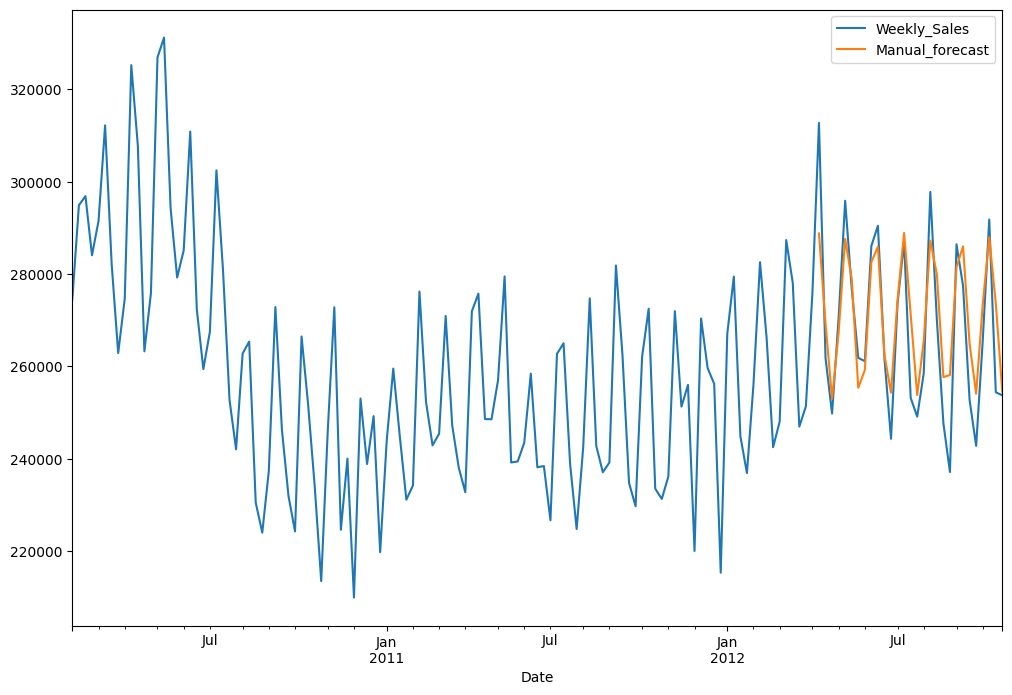

In [ ]:
model = sm.tsa.arima.ARIMA(train['Weekly_Sales'],order=(4,1,9))
model_fit =  model.fit()
model_data['Manual_forecast']=model_fit.predict(start=split_ind,end=(l-1),dynamic=True)
model_data[['Weekly_Sales','Manual_forecast']].plot(figsize=(12,8))

<Axes: xlabel='Date'>

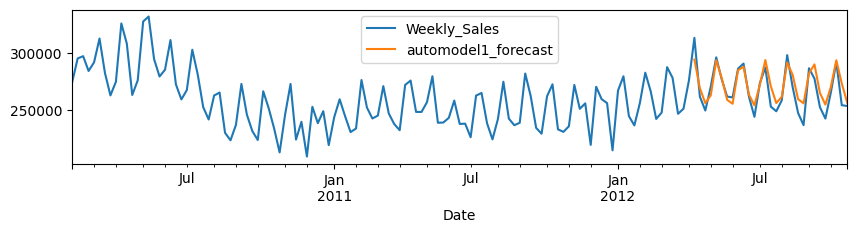

In [ ]:
automodel1 = sm.tsa.arima.ARIMA(train['Weekly_Sales'],order=(6,1,6))
automodel1_fit =  automodel1.fit()
model_data['automodel1_forecast']=automodel1_fit.predict(start=split_ind,end=(l-1),dynamic=True)
model_data[['Weekly_Sales','automodel1_forecast']].plot(figsize=(10,2))

In [ ]:
error_cal(test['Weekly_Sales'],model_data['automodel1_forecast'][split_ind:], " ARIMA" )

mae -  ARIMA : 7592.865075207857
mape -  ARIMA : 0.028958169905391656
rmse -  ARIMA : 9434.701885042692




/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)


<Axes: xlabel='Date'>

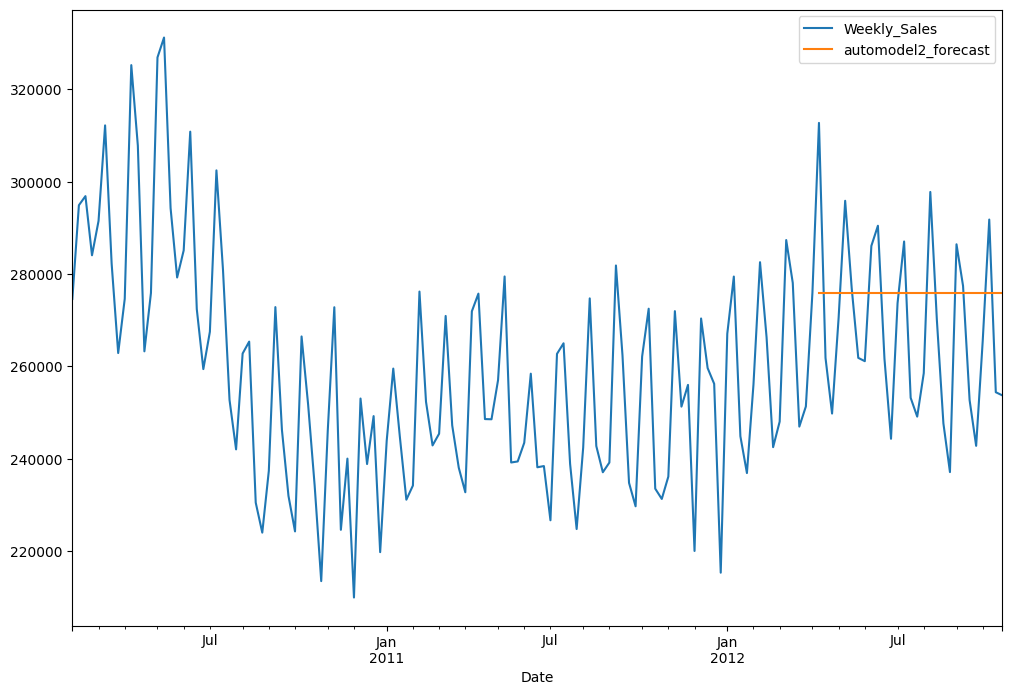

In [ ]:
automodel2 = sm.tsa.arima.ARIMA(train['Weekly_Sales'],order=(0,1,0))
automodel2_fit =  automodel2.fit()
model_data['automodel2_forecast']=automodel2_fit.predict(start=split_ind,end=(l-1),dynamic=True)
model_data[['Weekly_Sales','automodel2_forecast']].plot(figsize=(12,8))

## SARIMA

In [ ]:
sarimaauto   = auto_arima(model_data['Weekly_Sales'],d=1,seasonal=True,max_order=None,m=52,trace=True,supress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[52] intercept   : AIC=inf, Time=11.42 sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=3280.797, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=3258.656, Time=0.91 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=3262.954, Time=3.14 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=3278.805, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[52] intercept   : AIC=3282.281, Time=0.06 sec
 ARIMA(1,1,0)(2,0,0)[52] intercept   : AIC=3258.645, Time=6.87 sec
 ARIMA(1,1,0)(2,0,1)[52] intercept   : AIC=3260.643, Time=13.16 sec
 ARIMA(1,1,0)(1,0,1)[52] intercept   : AIC=3258.679, Time=1.76 sec
 ARIMA(0,1,0)(2,0,0)[52] intercept   : AIC=3258.370, Time=6.96 sec
 ARIMA(0,1,0)(1,0,0)[52] intercept   : AIC=3258.207, Time=0.66 sec
 ARIMA(0,1,0)(1,0,1)[52] intercept   : AIC=3258.389, Time=1.45 sec
 ARIMA(0,1,0)(0,0,1)[52] intercept   : AIC=3263.316, Time=1.01 sec
 ARIMA(0,1,0)(2,0,1)[52] intercept   : AIC=3260.368, Time=9.90 sec
 ARIMA(0,1,1)(1,0,0)[5

In [ ]:
smodel=sm.tsa.statespace.SARIMAX(train['Weekly_Sales'],order=(2,1,5),seasonal_order=(1,0,0,52))
smodel_fit =  smodel.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
model_data['sarimax_forecast']=smodel_fit.predict(start=split_ind,end=(l-1),dynamic=True)


<Axes: xlabel='Date'>

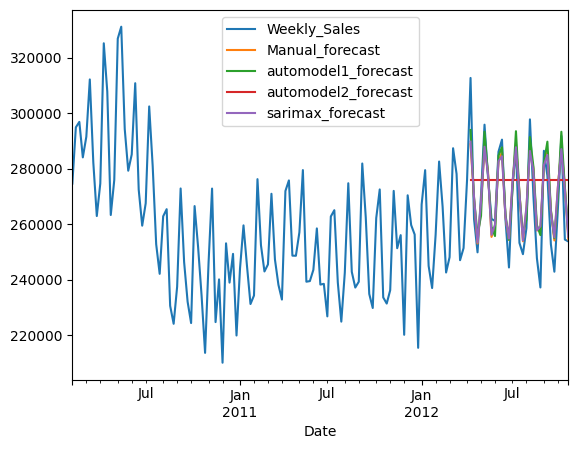

In [ ]:

model_data.loc[:, model_data. columns !='seasonal_first_difference'].plot()

In [ ]:
model_data. drop(['seasonal_first_difference','Manual_forecast', 'automodel1_forecast','automodel2_forecast'], axis=1).columns

Index(['Weekly_Sales', 'sarimax_forecast'], dtype='object')

<Axes: xlabel='Date'>

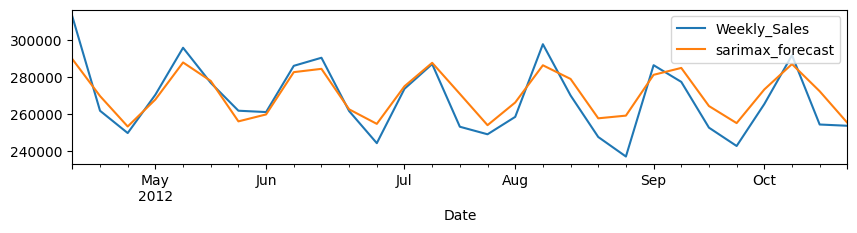

In [ ]:

model_data.loc[:,model_data. drop(['seasonal_first_difference','Manual_forecast', 'automodel1_forecast','automodel2_forecast'], axis=1).columns].iloc[split_ind:].plot(figsize=(10,2))

Error Calculation.

Making  Prediction for test data.

In [ ]:
forecast_marima=model_fit.forecast(len(test))
forecast_aarima1=automodel1_fit.forecast(len(test))
forecast_aarima2=automodel2_fit.forecast(len(test))
forecast_sarimax=smodel_fit.forecast(len(test))

In [ ]:
error_cal(test['Weekly_Sales'],forecast_marima, "Manual ARIMA" )
error_cal(test['Weekly_Sales'],forecast_aarima1, "Auto ARIMA" )
error_cal(test['Weekly_Sales'],forecast_aarima2, "Auto ARIMA" )
error_cal(test['Weekly_Sales'],forecast_sarimax, "Manual SARIMAX" )

mae - Manual ARIMA : 7855.976742750646
mape - Manual ARIMA : 0.029676968115471915
rmse - Manual ARIMA : 9959.704474451639


mae - Auto ARIMA : 7592.865075207857
mape - Auto ARIMA : 0.028958169905391656
rmse - Auto ARIMA : 9434.701885042692


mae - Auto ARIMA : 17789.436896551717
mape - Auto ARIMA : 0.06779792524517753
rmse - Auto ARIMA : 20451.26009022839


mae - Manual SARIMAX : 7848.558951691024
mape - Manual SARIMAX : 0.02968835693351052
rmse - Manual SARIMAX : 9907.411062303996




ARIMA gave best result

Forecasting

In [ ]:
main_data = dataset.loc[dataset['Store']==sn,['Date','Weekly_Sales']]
main_data=main_data.set_index('Date')

In [ ]:
main_data.head()

Weekly_Sales
Date                    
2010-02-05     274593.43
2010-02-12     294882.83
2010-02-19     296850.83
2010-02-26     284052.77
2010-03-05     291484.89

In [ ]:
future_dates=[main_data.index[-1]+ DateOffset(weeks=x)for x in range(0,12)]

In [ ]:
futuredates_df = pd.DataFrame(index=future_dates[1:],columns = ['Weekly_Sales'])

In [ ]:
futuredates_df.head()


Weekly_Sales
2012-11-02          NaN
2012-11-09          NaN
2012-11-16          NaN
2012-11-23          NaN
2012-11-30          NaN

In [ ]:
future_df=pd.concat([main_data,futuredates_df])

<Axes: >

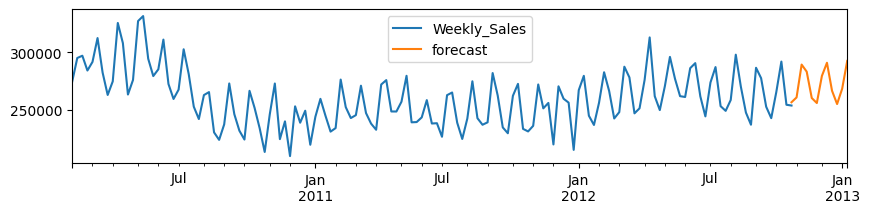

In [ ]:
future_df['forecast'] = automodel1_fit.predict(start = 142, end = 153, dynamic= True)
future_df[['Weekly_Sales', 'forecast']].plot(figsize=(10, 2))

For Store 44

In [ ]:
model_data=dataset.copy()
sn=44 #store number
model_data = model_data.loc[dataset['Store']==sn,['Date','Weekly_Sales']]
model_data.set_index('Date',inplace=True)
model_data.tail()

Weekly_Sales
Date                    
2012-09-28     355307.94
2012-10-05     337390.44
2012-10-12     337796.13
2012-10-19     323766.77
2012-10-26     361067.07

In [ ]:
model_data.dtypes

Weekly_Sales    float64
dtype: object

In [ ]:
model_data.shape

(143, 1)

<Axes: xlabel='Date'>

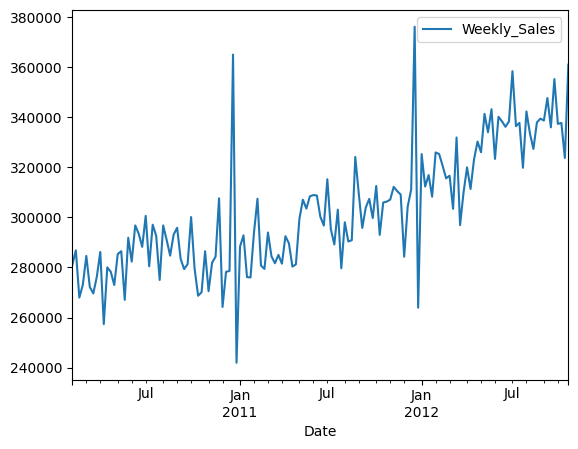

In [ ]:
model_data.plot()

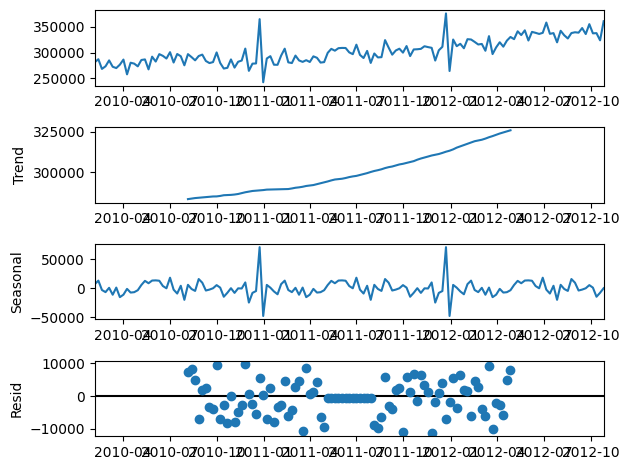

In [ ]:

from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot
result = seasonal_decompose(model_data, model='additive')
result.plot()
pyplot.show()

ADF Stationarity Test and KPSS Stationarity Test

In [ ]:
adfuller_test(model_data['Weekly_Sales'])

 H0 : It is non-stationary
 H1 : It is Stationary
ADF Test Statistic : -0.9837026947465893
p-value : 0.7591618635707303
Lags Used : 3
Numer of Observations Used : 139
	1%: -3.478
	5%: -2.883
	10%: -2.578
Weak evidence against Null Hypothesis. Accept Null Hypothesis


In [ ]:
kpss_test(model_data['Weekly_Sales'])

 H0 : It is stationary
 H1 : It is  non-stationary
Test Statistic: 0.342260
p-value: 0.010000
Critical values:
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


For store 44, weekly sales timeseries ADF concludes non stationary, and KPSS concludes non-stationary

 Making  it stationary

In [ ]:
model_data['log_weekly_sales']=np.log(model_data['Weekly_Sales'])
model_data['log_weekly_sales']=model_data['log_weekly_sales'].dropna()

In [ ]:
model_data.describe()

Weekly_Sales  log_weekly_sales
count     143.000000        143.000000
mean   302748.866014         12.617398
std     24762.832015          0.080715
min    241937.110000         12.396433
25%    283882.235000         12.556314
50%    298080.450000         12.605119
75%    319938.180000         12.675883
max    376233.890000         12.837966

<Axes: xlabel='Date'>

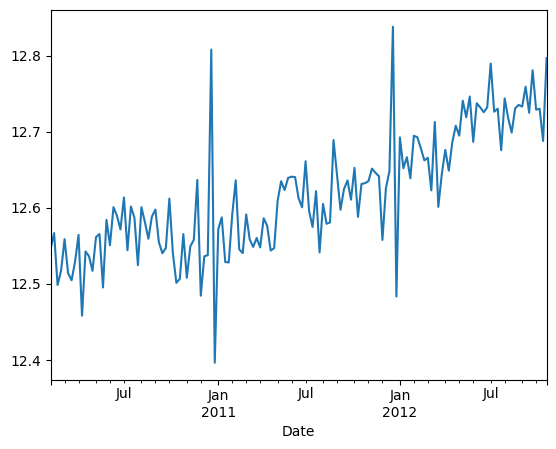

In [ ]:
mean_log=model_data['log_weekly_sales'].rolling(window=52).mean()
std_log=model_data['log_weekly_sales'].rolling(window=52).std()
model_data["log_weekly_sales"].plot()

In [ ]:
new_data= model_data['log_weekly_sales'] - mean_log
new_data=new_data.dropna()
model_data['new_data']= new_data
new_data_mean=model_data['new_data'].rolling(window=12).mean()
new_data_std=model_data['new_data'].rolling(window=12).std()



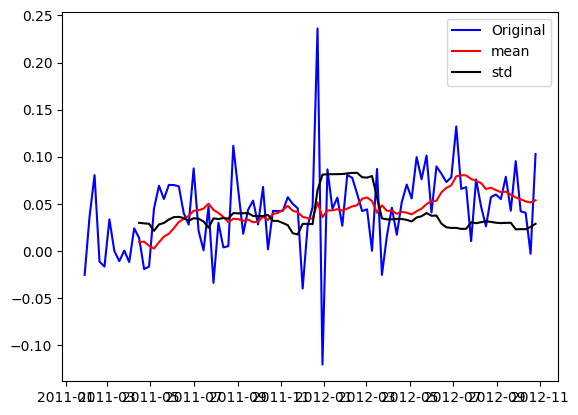

In [ ]:
plt.plot(new_data, color='Blue', label='Original')
plt.plot(new_data_mean, color='red', label='mean')
plt.plot(new_data_std, color='black', label='std')
plt.legend(loc='best')
plt.show()

In [ ]:
adfuller_test(model_data['new_data'].dropna())

 H0 : It is non-stationary
 H1 : It is Stationary
ADF Test Statistic : -10.095497187487736
p-value : 1.0936308370802817e-17
Lags Used : 0
Numer of Observations Used : 91
	1%: -3.504
	5%: -2.894
	10%: -2.584
Strong evidence against Null Hypothesis. Reject Null Hypothesis


In [ ]:
kpss_test(model_data['new_data'].dropna())

 H0 : It is stationary
 H1 : It is  non-stationary
Test Statistic: 0.040841
p-value: 0.100000
Critical values:
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


Now the Timeseries is Stationary.

Manually selecting p,d,q values using charts

## Plotting ACF and PACF Plots

*   **Identification of AR Model is often done best with PACF.**
    <br><br>For an AR model, theoretical PACF shuts off  past the order of the model. The phrase shuts off  means that in theory the Partial autocorrelation are to 0 beyond that point.<br><br>
*   **Identification of MA Model is often done best with ACF rather than PACF.**
<br><br>For a MA model, theoritical PACF does not shuts off but instead tapers towards 0. The ACF  will have non-zero auto-correlations only at lags involved in the model.



In [ ]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm

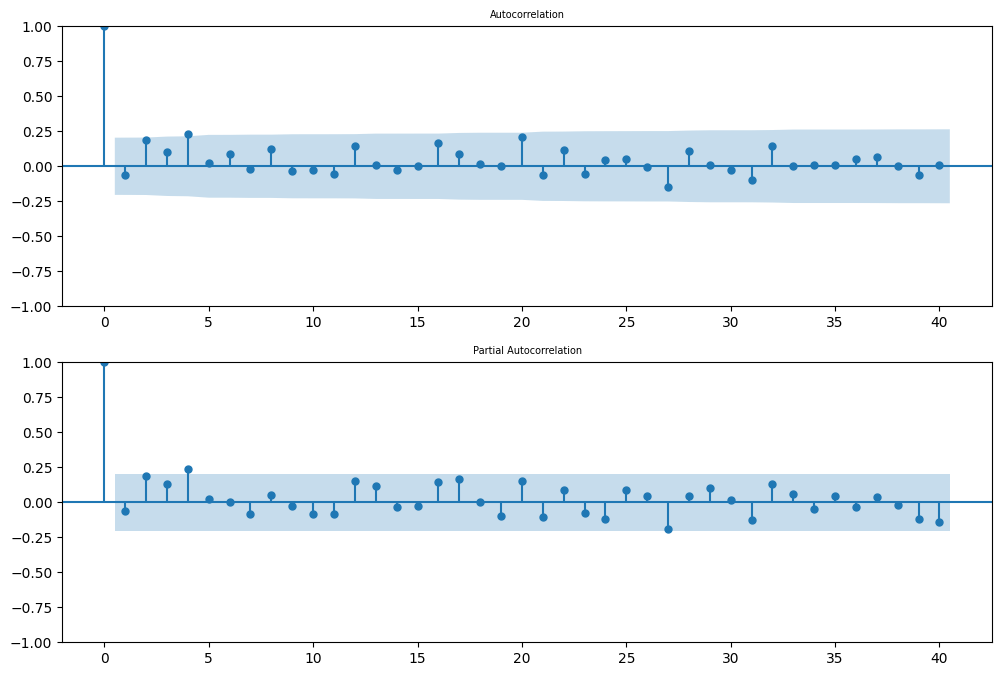

In [ ]:
fig=plt.figure(figsize=(12,8))
ax1= fig.add_subplot(211)
fig= sm.graphics.tsa.plot_acf(model_data['new_data'].dropna(), lags=40,ax=ax1)
ax2= fig.add_subplot(212)
fig= sm.graphics.tsa.plot_pacf(model_data['new_data'].dropna(), lags=40,ax=ax2)


P =  1/2/3 <br>
D = 1 <br>
Q = 0/4 <br>

Using Auto arima for Optimal p,d,q values based on  AIC Criterion

In [ ]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 6.8 MB/s eta 0:00:00


Using without stepwise

In [ ]:
from pmdarima import auto_arima
arimaauto1   = auto_arima(model_data['Weekly_Sales'],stepwise =False,max_p =10, max_q=10 ,trace=True,supress_warnings=True,max_order=None, n_fits=10)

 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=3253.446, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=3249.649, Time=0.22 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=3245.530, Time=0.28 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=3250.653, Time=0.25 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=3246.373, Time=0.34 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=3252.466, Time=0.32 sec
 ARIMA(0,1,6)(0,0,0)[1] intercept   : AIC=3255.285, Time=0.36 sec
 ARIMA(0,1,7)(0,0,0)[1] intercept   : AIC=3251.198, Time=0.43 sec
 ARIMA(0,1,8)(0,0,0)[1] intercept   : AIC=3255.575, Time=0.74 sec
 ARIMA(0,1,9)(0,0,0)[1] intercept   : AIC=3258.176, Time=1.13 sec
 ARIMA(0,1,10)(0,0,0)[1] intercept   : AIC=3252.287, Time=1.29 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=3235.639, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=3224.453, Time=0.50 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=3250.475, Time=0.39 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.85 sec
 ARIMA(1,1,4)(

In [ ]:
arimaauto1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   92
Model:               SARIMAX(0, 1, 3)   Log Likelihood                 159.084
Date:                Fri, 28 Jul 2023   AIC                           -308.169
Time:                        12:41:08   BIC                           -295.614
Sample:                    01-28-2011   HQIC                          -303.104
                         - 10-26-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0005      0.000      2.327      0.020    8.44e-05       0.001
ma.L1         -1.2220      0.152     -8.020      0.000      -1.521      -0.923
ma.L2          0.3696      0.162      2.275      0.023       0.051       0.688
ma.L3         -0.1340      0.151     -0.885      0.376      -0.431       0.163
sigma2         0.0017      0.000      5.951      0.000       0.001       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.43   Jarque-Bera (JB):                99.88
Prob(Q):                              0.51   Prob(JB):                         0.00
Heteroskedasticity (H):               0.64   Skew:                             0.84
Prob(H) (two-sided):                  0.23   Kurtosis:                         7.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Using Stepwise.

In [ ]:
arimaauto2   = auto_arima(model_data['Weekly_Sales'],trace=True,supress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.48 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3253.446, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3235.639, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3249.649, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3251.538, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3240.787, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3224.453, Time=0.25 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3257.580, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3250.475, Time=0.18 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3245.530, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3253.195, Time=0.09 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.587 seconds


In [ ]:
arimaauto2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  143
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -1608.227
Date:                Fri, 28 Jul 2023   AIC                           3224.453
Time:                        12:41:11   BIC                           3236.276
Sample:                    02-05-2010   HQIC                          3229.258
                         - 10-26-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    641.2594    963.684      0.665      0.506   -1247.527    2530.046
ar.L1          0.1155      0.072      1.607      0.108      -0.025       0.256
ma.L1         -0.5439      0.092     -5.917      0.000      -0.724      -0.364
sigma2      3.973e+08      0.003   1.29e+11      0.000    3.97e+08    3.97e+08
===================================================================================
Ljung-Box (L1) (Q):                  13.96   Jarque-Bera (JB):               526.30
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.56   Skew:                             0.45
Prob(H) (two-sided):                  0.05   Kurtosis:                        12.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.25e+26. Standard errors may be unstable.
"""

Now Splitting Data and Building Model

In [ ]:
l=len( model_data)
split_ind = int(l*0.8)
train = model_data.iloc[0: split_ind]
test = model_data.iloc[split_ind : l]


## ARIMA

In [ ]:
 from statsmodels.tsa.arima_model import ARIMA

Using Manually identified PDQ

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)


<Axes: xlabel='Date'>

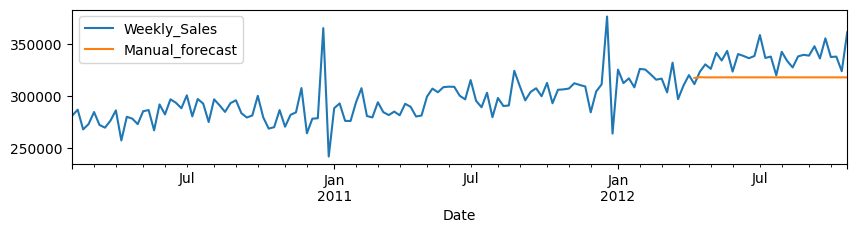

In [ ]:
model = sm.tsa.arima.ARIMA(train['Weekly_Sales'],order=(1,1,0))
model_fit =  model.fit()
model_data['Manual_forecast']=model_fit.predict(start=split_ind,end=(l-1),dynamic=True)
model_data[['Weekly_Sales','Manual_forecast']].plot(figsize=(10,2))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)


<Axes: xlabel='Date'>

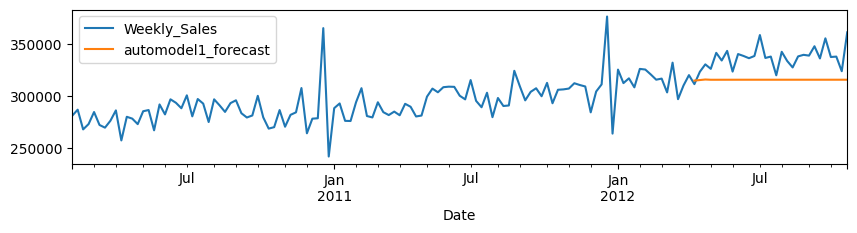

In [ ]:
automodel1 = sm.tsa.arima.ARIMA(train['Weekly_Sales'],order=(2,1,0))
automodel1_fit =  automodel1.fit()
model_data['automodel1_forecast']=automodel1_fit.predict(start=split_ind,end=(l-1),dynamic=True)
model_data[['Weekly_Sales','automodel1_forecast']].plot(figsize=(10,2))


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)


<Axes: xlabel='Date'>

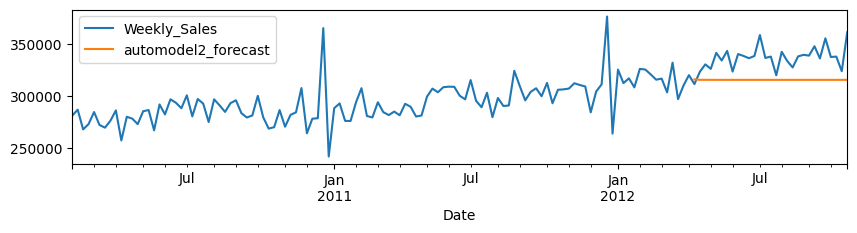

In [ ]:
automodel2 = sm.tsa.arima.ARIMA(train['Weekly_Sales'],order=(1,1,1))
automodel2_fit =  automodel2.fit()
model_data['automodel2_forecast']=automodel2_fit.predict(start=split_ind,end=(l-1),dynamic=True)
model_data[['Weekly_Sales','automodel2_forecast']].plot(figsize=(10,2))


In [ ]:
model_data['Manual_forecast'].shape

(143,)

In [ ]:
error_cal(test['Weekly_Sales'],model_data['Manual_forecast'][split_ind:], "manual arima" )
error_cal(test['Weekly_Sales'],model_data['automodel1_forecast'][split_ind:], "arima1 " )
error_cal(test['Weekly_Sales'],model_data['automodel2_forecast'][split_ind:], "arima2 " )


mae - manual arima : 19003.032788777284
mape - manual arima : 0.05560990378113388
rmse - manual arima : 21476.023529585622


mae - arima1  : 21132.944783513158
mape - arima1  : 0.06190874705436625
rmse - arima1  : 23484.03192731933


mae - arima2  : 21284.317594056356
mape - arima2  : 0.062366311315592754
rmse - arima2  : 23599.671942968413




ARIMA is not working well.

## SARIMA

In [ ]:
sarimaauto   = auto_arima(model_data['Weekly_Sales'],d=0,seasonal=True,max_order=None,m=52,trace=True,supress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[52] intercept   : AIC=3153.054, Time=12.44 sec
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=3302.303, Time=0.06 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=3238.113, Time=1.42 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=3268.530, Time=0.84 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=4018.272, Time=0.02 sec
 ARIMA(2,0,2)(0,0,1)[52] intercept   : AIC=3151.242, Time=5.01 sec
 ARIMA(2,0,2)(0,0,0)[52] intercept   : AIC=3173.555, Time=0.63 sec
 ARIMA(2,0,2)(0,0,2)[52] intercept   : AIC=3150.397, Time=21.88 sec
 ARIMA(2,0,2)(1,0,2)[52] intercept   : AIC=inf, Time=40.22 sec
 ARIMA(1,0,2)(0,0,2)[52] intercept   : AIC=3156.302, Time=11.32 sec
 ARIMA(2,0,1)(0,0,2)[52] intercept   : AIC=3162.097, Time=13.22 sec
 ARIMA(3,0,2)(0,0,2)[52] intercept   : AIC=3149.057, Time=32.22 sec
 ARIMA(3,0,2)(0,0,1)[52] intercept   : AIC=3150.378, Time=6.32 sec
 ARIMA(3,0,2)(1,0,2)[52] intercept   : AIC=3149.845, Time=47.63 sec
 ARIMA(3,0,2)(1,0

In [ ]:
smodel1=sm.tsa.statespace.SARIMAX(train['Weekly_Sales'],order=(3,1,3),seasonal_order=(1,0,2,52))
smodel1_fit =  smodel1.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
smodel2=sm.tsa.statespace.SARIMAX(train['Weekly_Sales'],order=(1,1,0),seasonal_order=(1,1,0,52.5))
smodel2_fit =  smodel2.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)


In [ ]:
smodel3=sm.tsa.statespace.SARIMAX(train['Weekly_Sales'],order=(2,1,0),seasonal_order=(2,1,0,52.5))
smodel3_fit =  smodel3.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)


In [ ]:
sm1=smodel1_fit.predict(start=split_ind,end=(l-1),dynamic=True)
sm2=smodel2_fit.predict(start=split_ind,end=(l-1),dynamic=True)
sm3=smodel3_fit.predict(start=split_ind,end=(l-1),dynamic=True)


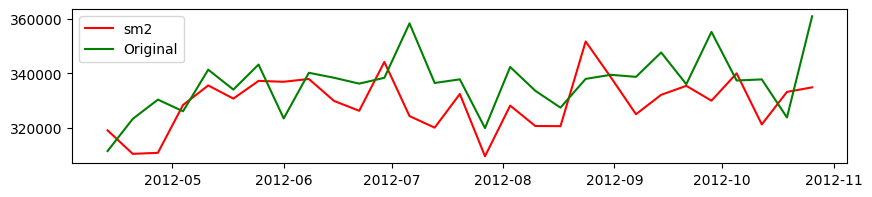

In [ ]:
fig=plt.figure(figsize=(10,2))
plt.plot(sm2, color='red', label='sm2')
plt.plot(test['Weekly_Sales'], color='Green', label='Original')
plt.legend(loc='best')
plt.show()

Error Calculation.

Making  Prediction for test data.Will only be sing Sarima model

In [ ]:
error_cal(test['Weekly_Sales'],sm1, "sm1 " )
error_cal(test['Weekly_Sales'],sm2, "sm2 " )
error_cal(test['Weekly_Sales'],sm3, "sm3 " )


mae - sm1  : 17146.184061695003
mape - sm1  : 0.05028425523784645
rmse - sm1  : 19267.20499190344


mae - sm2  : 11143.809076858543
mape - sm2  : 0.03279415503567353
rmse - sm2  : 13658.975246868245


mae - sm3  : 12853.170256627951
mape - sm3  : 0.03764680230578649
rmse - sm3  : 15418.805041377107




sm2 is best fit


Forecasting

In [ ]:
main_data = dataset.loc[dataset['Store']==sn,['Date','Weekly_Sales']]
main_data=main_data.set_index('Date')

In [ ]:
main_data.head()

Weekly_Sales
Date                    
2010-02-05     281090.95
2010-02-12     286857.13
2010-02-19     267956.30
2010-02-26     273079.07
2010-03-05     284617.27

In [ ]:
from pandas.tseries.offsets import DateOffset
future_dates=[main_data.index[-1]+ DateOffset(weeks=x)for x in range(0,12)]

In [ ]:
futuredates_df = pd.DataFrame(index=future_dates[1:],columns = ['Weekly_Sales'])

In [ ]:
futuredates_df.head()


Weekly_Sales
2012-11-02          NaN
2012-11-09          NaN
2012-11-16          NaN
2012-11-23          NaN
2012-11-30          NaN

In [ ]:
future_df=pd.concat([main_data,futuredates_df])

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/kalman_filter.py:2290: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


<Axes: >

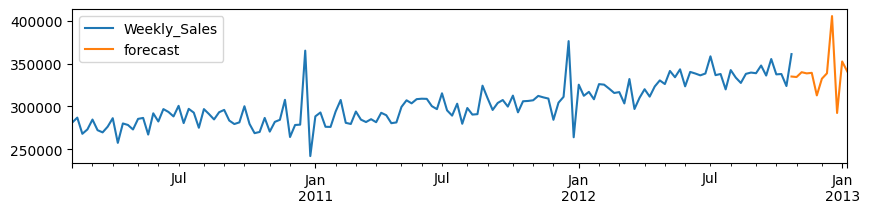

In [ ]:
future_df['forecast'] = smodel2_fit.predict(start = 142, end = 153, dynamic= True)
future_df[['Weekly_Sales', 'forecast']].plot(figsize=(10, 2))

For Store 5

In [ ]:
model_data=dataset.copy()
sn=5 #store number
model_data = model_data.loc[dataset['Store']==sn,['Date','Weekly_Sales']]
model_data.set_index('Date',inplace=True)
model_data.tail()

Weekly_Sales
Date                    
2012-09-28     310141.68
2012-10-05     343048.29
2012-10-12     325345.41
2012-10-19     313358.15
2012-10-26     319550.77

In [ ]:
model_data.dtypes

Weekly_Sales    float64
dtype: object

In [ ]:
model_data.shape

(143, 1)

<Axes: xlabel='Date'>

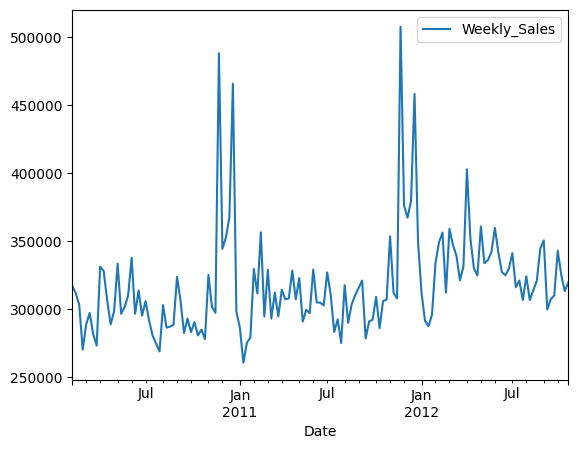

In [ ]:
model_data.plot()

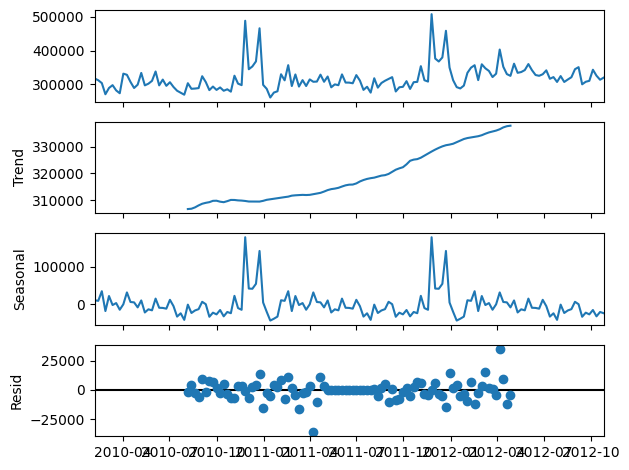

In [ ]:

from matplotlib import pyplot
result = seasonal_decompose(model_data, model='additive')
result.plot()
pyplot.show()

ADF Stationarity Test and KPSS Stationarity Test

In [ ]:
adfuller_test(model_data['Weekly_Sales'])

 H0 : It is non-stationary
 H1 : It is Stationary
ADF Test Statistic : -4.310974424060915
p-value : 0.00042517056141923293
Lags Used : 4
Numer of Observations Used : 138
	1%: -3.479
	5%: -2.883
	10%: -2.578
Strong evidence against Null Hypothesis. Reject Null Hypothesis


In [ ]:
kpss_test(model_data['Weekly_Sales'])

 H0 : It is stationary
 H1 : It is  non-stationary
Test Statistic: 0.055789
p-value: 0.100000
Critical values:
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216


For store 5, weekly sales timeseries ADF concludes  stationary, and KPSS also concludes stationary

 Checking  its stationary visually using rolling window.

In [ ]:
data_mean=model_data['Weekly_Sales'].rolling(window=52).mean()
data_std=model_data['Weekly_Sales'].rolling(window=52).std()

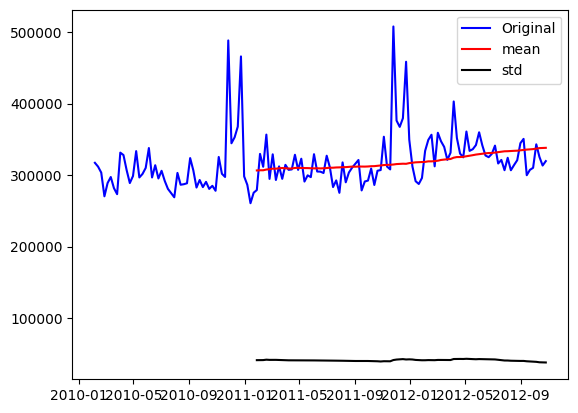

In [ ]:
plt.plot(model_data['Weekly_Sales'], color='Blue', label='Original')
plt.plot(data_mean, color='red', label='mean')
plt.plot(data_std, color='black', label='std')
plt.legend(loc='best')
plt.show()

Looks Stationary but has seasonality

Manually selecting p,d,q values using charts

## Plotting ACF and PACF Plots

*   **Identification of AR Model is often done best with PACF.**
    <br><br>For an AR model, theoretical PACF shuts off  past the order of the model. The phrase shuts off  means that in theory the Partial autocorrelation are to 0 beyond that point.<br><br>
*   **Identification of MA Model is often done best with ACF rather than PACF.**
<br><br>For a MA model, theoritical PACF does not shuts off but instead tapers towards 0. The ACF  will have non-zero auto-correlations only at lags involved in the model.



In [ ]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm

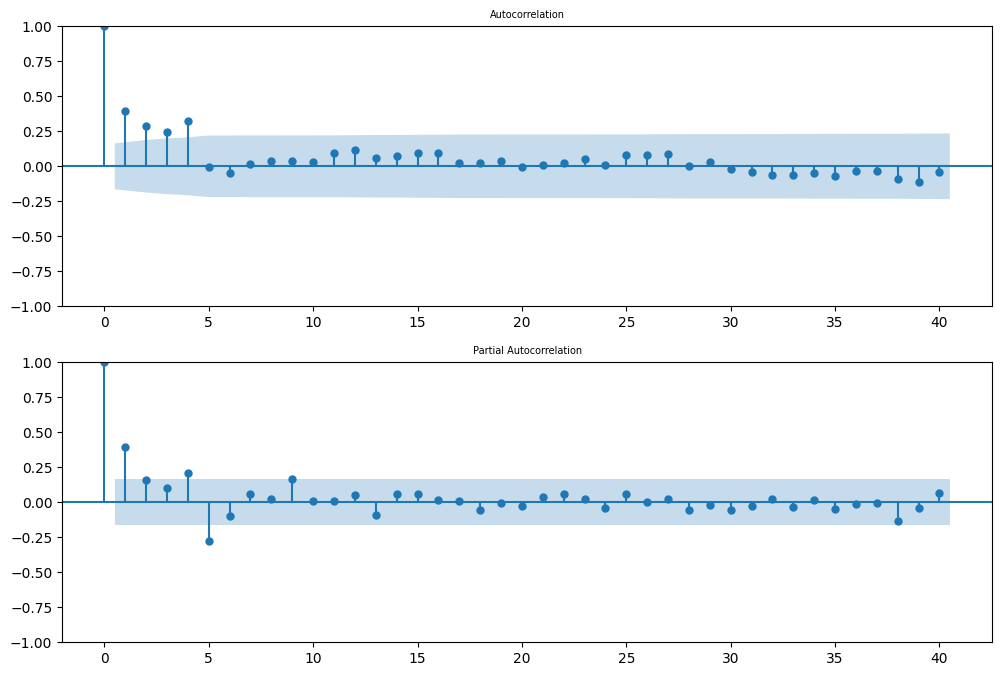

In [ ]:
fig=plt.figure(figsize=(12,8))
ax1= fig.add_subplot(211)
fig= sm.graphics.tsa.plot_acf(model_data['Weekly_Sales'].dropna(), lags=40,ax=ax1)
ax2= fig.add_subplot(212)
fig= sm.graphics.tsa.plot_pacf(model_data['Weekly_Sales'].dropna(), lags=40,ax=ax2)


P =  3 <br>
D = 0 <br>
Q = 1/2/3/4 <br>

Using Auto arima for Optimal p,d,q values based on  AIC Criterion

Using without stepwise

In [ ]:

arimaauto1   = auto_arima(model_data['Weekly_Sales'],stepwise =False,d=0,max_p =10, max_q=10 ,trace=True,supress_warnings=True,max_order=None, n_fits=10)

 ARIMA(0,0,0)(0,0,0)[1] intercept   : AIC=3422.802, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[1] intercept   : AIC=3408.895, Time=0.06 sec
 ARIMA(0,0,2)(0,0,0)[1] intercept   : AIC=3404.843, Time=0.07 sec
 ARIMA(0,0,3)(0,0,0)[1] intercept   : AIC=3407.206, Time=0.09 sec
 ARIMA(0,0,4)(0,0,0)[1] intercept   : AIC=3380.682, Time=0.13 sec
 ARIMA(0,0,5)(0,0,0)[1] intercept   : AIC=3382.965, Time=0.15 sec
 ARIMA(0,0,6)(0,0,0)[1] intercept   : AIC=3385.121, Time=0.18 sec
 ARIMA(0,0,7)(0,0,0)[1] intercept   : AIC=3387.198, Time=0.20 sec
 ARIMA(0,0,8)(0,0,0)[1] intercept   : AIC=3389.384, Time=0.26 sec
 ARIMA(0,0,9)(0,0,0)[1] intercept   : AIC=3391.334, Time=0.31 sec
 ARIMA(0,0,10)(0,0,0)[1] intercept   : AIC=3393.613, Time=0.42 sec
 ARIMA(1,0,0)(0,0,0)[1] intercept   : AIC=3400.997, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[1] intercept   : AIC=3399.951, Time=0.07 sec
 ARIMA(1,0,2)(0,0,0)[1] intercept   : AIC=3402.674, Time=0.12 sec
 ARIMA(1,0,3)(0,0,0)[1] intercept   : AIC=3400.335, Time=0.13 sec
 ARIMA(1,

In [ ]:
arimaauto1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  143
Model:               SARIMAX(0, 0, 4)   Log Likelihood               -1684.341
Date:                Fri, 28 Jul 2023   AIC                           3380.682
Time:                        23:10:04   BIC                           3398.459
Sample:                    02-05-2010   HQIC                          3387.906
                         - 10-26-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   3.192e+05   8386.684     38.058      0.000    3.03e+05    3.36e+05
ma.L1          0.3183      0.108      2.953      0.003       0.107       0.529
ma.L2          0.2665      0.131      2.031      0.042       0.009       0.524
ma.L3          0.2224      0.102      2.182      0.029       0.023       0.422
ma.L4          0.5064      0.093      5.465      0.000       0.325       0.688
sigma2      1.199e+09      0.583   2.05e+09      0.000     1.2e+09     1.2e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):              1795.14
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               0.51   Skew:                             3.06
Prob(H) (two-sided):                  0.02   Kurtosis:                        19.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.27e+24. Standard errors may be unstable.
"""

Using Stepwise.

In [ ]:
arimaauto2   = auto_arima(model_data['Weekly_Sales'],trace=True,d=0,supress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=3400.559, Time=0.38 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=3422.802, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=3400.997, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=3408.895, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=4033.378, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=3402.674, Time=0.10 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=3400.818, Time=0.12 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=3402.385, Time=0.52 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=3395.761, Time=0.42 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=3400.335, Time=0.13 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=3395.662, Time=0.54 sec
 ARIMA(4,0,3)(0,0,0)[0] intercept   : AIC=3393.596, Time=0.38 sec
 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=3391.616, Time=0.29 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=3394.281, Time=0.22 sec
 ARIMA(5,0,2)(0,0,0)[0] intercept

In [ ]:
arimaauto2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  143
Model:               SARIMAX(5, 0, 0)   Log Likelihood               -1686.141
Date:                Fri, 28 Jul 2023   AIC                           3386.282
Time:                        23:10:11   BIC                           3407.021
Sample:                    02-05-2010   HQIC                          3394.709
                         - 10-26-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    1.49e+05   3.71e+04      4.017      0.000    7.63e+04    2.22e+05
ar.L1          0.3487      0.084      4.154      0.000       0.184       0.513
ar.L2          0.1067      0.098      1.088      0.277      -0.086       0.299
ar.L3          0.0630      0.078      0.809      0.419      -0.090       0.216
ar.L4          0.2862      0.058      4.968      0.000       0.173       0.399
ar.L5         -0.2728      0.084     -3.248      0.001      -0.437      -0.108
sigma2      1.038e+09      8.150   1.27e+08      0.000    1.04e+09    1.04e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):              1445.58
Prob(Q):                              0.76   Prob(JB):                         0.00
Heteroskedasticity (H):               0.49   Skew:                             2.86
Prob(H) (two-sided):                  0.02   Kurtosis:                        17.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.82e+29. Standard errors may be unstable.
"""

Now Splitting Data and Building Model

In [ ]:
l=len( model_data)
split_ind = int(l*0.8)
train = model_data.iloc[0: split_ind]
test = model_data.iloc[split_ind : l]


## ARIMA

Using Manually identified PDQ

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)


<Axes: xlabel='Date'>

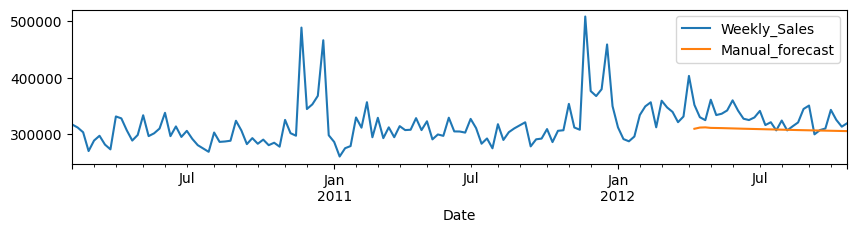

In [ ]:
model = sm.tsa.arima.ARIMA(train['Weekly_Sales'],order=(3,0,1))
model_fit =  model.fit()
model_data['Manual_forecast']=model_fit.predict(start=split_ind,end=(l-1),dynamic=True)
model_data[['Weekly_Sales','Manual_forecast']].plot(figsize=(10,2))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)


<Axes: xlabel='Date'>

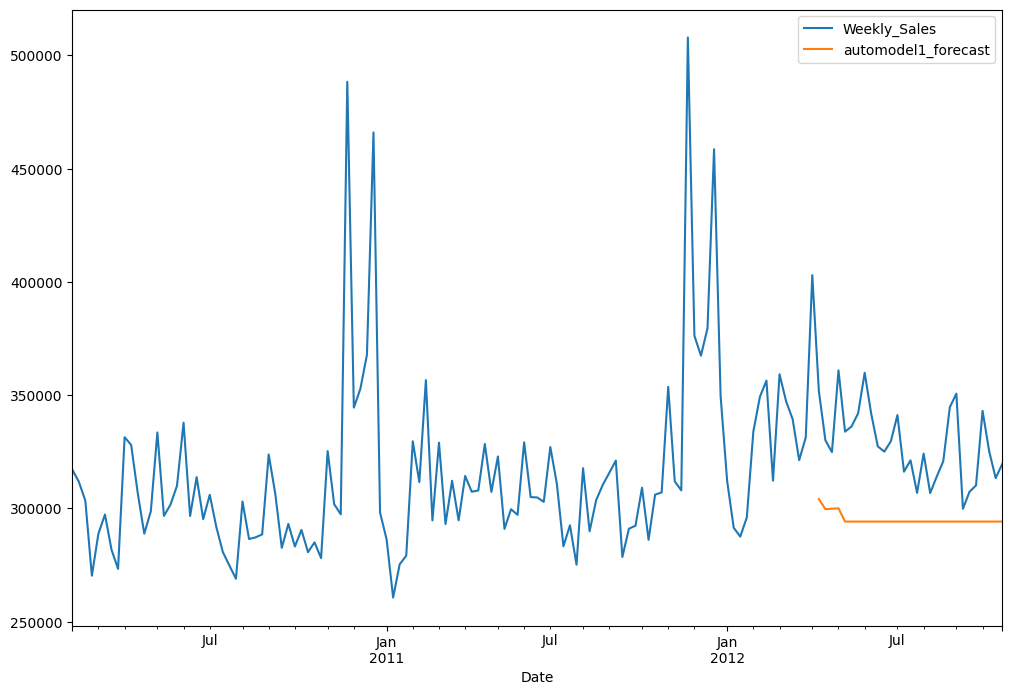

In [ ]:
automodel1 = sm.tsa.arima.ARIMA(train['Weekly_Sales'],order=(0,0,4))
automodel1_fit =  automodel1.fit()
model_data['automodel1_forecast']=automodel1_fit.predict(start=split_ind,end=(l-1),dynamic=True)
model_data[['Weekly_Sales','automodel1_forecast']].plot(figsize=(12,8))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)


<Axes: xlabel='Date'>

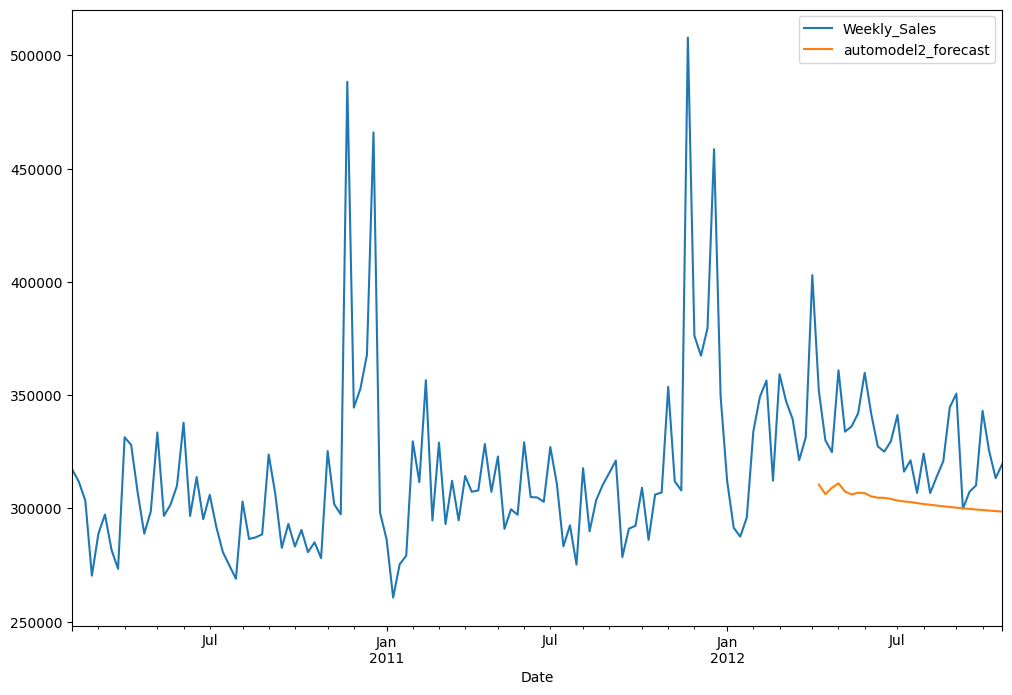

In [ ]:
automodel2 = sm.tsa.arima.ARIMA(train['Weekly_Sales'],order=(5,0,0))
automodel2_fit =  automodel2.fit()
model_data['automodel2_forecast']=automodel2_fit.predict(start=split_ind,end=(l-1),dynamic=True)
model_data[['Weekly_Sales','automodel2_forecast']].plot(figsize=(12,8))

In [ ]:
error_cal(test['Weekly_Sales'],model_data['Manual_forecast'][split_ind:], "manual arima" )
error_cal(test['Weekly_Sales'],model_data['automodel1_forecast'][split_ind:], "arima1 " )
error_cal(test['Weekly_Sales'],model_data['automodel2_forecast'][split_ind:], "arima2 " )

mae - manual arima : 27928.59023804646
mape - manual arima : 0.08200118710803056
rmse - manual arima : 30236.678373933984


mae - arima1  : 41369.01921836521
mape - arima1  : 0.12191714646949312
rmse - arima1  : 43156.759451366976


mae - arima2  : 33155.82661393019
mape - arima2  : 0.09746347701961393
rmse - arima2  : 35523.99616828324




ARIMA is not working well.

## SARIMA

In [ ]:
sarimaauto   = auto_arima(model_data['Weekly_Sales'],d=0,D=1,seasonal=True,m=52,trace=True,supress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[52] intercept   : AIC=inf, Time=45.46 sec
 ARIMA(0,0,0)(0,1,0)[52] intercept   : AIC=2047.757, Time=0.18 sec
 ARIMA(1,0,0)(1,1,0)[52] intercept   : AIC=2050.022, Time=3.62 sec
 ARIMA(0,0,1)(0,1,1)[52] intercept   : AIC=2044.184, Time=5.28 sec
 ARIMA(0,0,0)(0,1,0)[52]             : AIC=2109.217, Time=0.29 sec
 ARIMA(0,0,1)(0,1,0)[52] intercept   : AIC=2048.010, Time=0.62 sec
 ARIMA(0,0,1)(1,1,1)[52] intercept   : AIC=inf, Time=18.36 sec
 ARIMA(0,0,1)(0,1,2)[52] intercept   : AIC=2036.436, Time=17.02 sec
 ARIMA(0,0,1)(1,1,2)[52] intercept   : AIC=inf, Time=79.42 sec
 ARIMA(0,0,0)(0,1,2)[52] intercept   : AIC=2035.718, Time=7.06 sec
 ARIMA(0,0,0)(0,1,1)[52] intercept   : AIC=2042.004, Time=5.98 sec
 ARIMA(0,0,0)(1,1,2)[52] intercept   : AIC=inf, Time=41.34 sec
 ARIMA(0,0,0)(1,1,1)[52] intercept   : AIC=inf, Time=11.42 sec
 ARIMA(1,0,0)(0,1,2)[52] intercept   : AIC=2037.092, Time=15.23 sec
 ARIMA(1,0,1)(0,1,2)[52] intercept   

In [ ]:
sarimaauto2   = auto_arima(model_data['Weekly_Sales'],d=1,seasonal=True,m=52,trace=True,supress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[52] intercept   : AIC=3367.275, Time=9.51 sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=3427.452, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=3371.691, Time=1.20 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=3368.802, Time=1.10 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=3425.456, Time=0.03 sec
 ARIMA(2,1,2)(0,0,1)[52] intercept   : AIC=3372.856, Time=4.65 sec
 ARIMA(2,1,2)(1,0,0)[52] intercept   : AIC=3365.811, Time=7.20 sec
 ARIMA(2,1,2)(0,0,0)[52] intercept   : AIC=inf, Time=0.53 sec
 ARIMA(2,1,2)(2,0,0)[52] intercept   : AIC=3367.214, Time=27.08 sec
 ARIMA(2,1,2)(2,0,1)[52] intercept   : AIC=3369.199, Time=33.49 sec
 ARIMA(1,1,2)(1,0,0)[52] intercept   : AIC=3364.734, Time=3.13 sec
 ARIMA(1,1,2)(0,0,0)[52] intercept   : AIC=3398.543, Time=0.35 sec
 ARIMA(1,1,2)(2,0,0)[52] intercept   : AIC=3366.251, Time=11.74 sec
 ARIMA(1,1,2)(1,0,1)[52] intercept   : AIC=3366.342, Time=5.22 sec
 ARIMA(1,1,2)(0,0,1)[

In [ ]:
smodel1=sm.tsa.statespace.SARIMAX(train['Weekly_Sales'],order=(3,0,1),seasonal_order=(0,1,2,52))
smodel1_fit =  smodel1.fit()

In [ ]:
smodel2=sm.tsa.statespace.SARIMAX(train['Weekly_Sales'],order=(3,0,1),seasonal_order=(0,1,3,52))
smodel2_fit =  smodel2.fit()

In [ ]:
smodel3=sm.tsa.statespace.SARIMAX(train['Weekly_Sales'],order=(3,0,1),seasonal_order=(0,1,1,52))
smodel3_fit =  smodel3.fit()

In [ ]:
sm1=smodel1_fit.predict(start=split_ind,end=(l-1),dynamic=True)
sm2=smodel2_fit.predict(start=split_ind,end=(l-1),dynamic=True)
sm3=smodel3_fit.predict(start=split_ind,end=(l-1),dynamic=True)


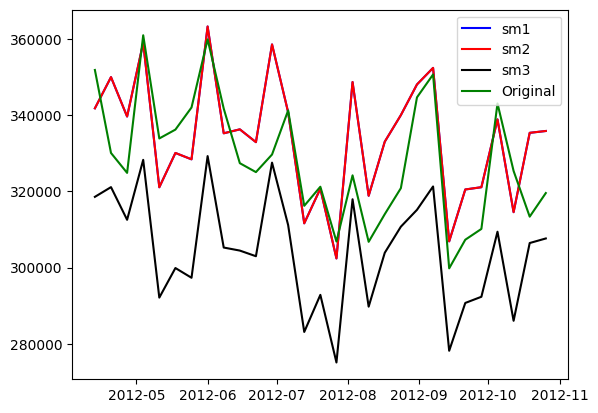

In [ ]:
plt.plot(sm1, color='Blue', label='sm1')
plt.plot(sm2, color='red', label='sm2')
plt.plot(sm3, color='black', label='sm3')
plt.plot(model_data['Weekly_Sales'].iloc[split_ind:], color='Green', label='Original')
plt.legend(loc='best')
plt.show()

Error Calculation.

Making  Prediction for test data.Will only be using Sarima model





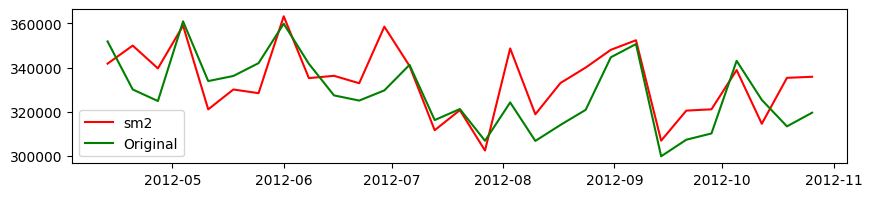

In [ ]:
fig=plt.figure(figsize=(10,2))
plt.plot(sm2, color='red', label='sm2')
plt.plot(test['Weekly_Sales'], color='Green', label='Original')
plt.legend(loc='best')
plt.show()

In [ ]:
error_cal(test['Weekly_Sales'],sm1, "sm1 " )
error_cal(test['Weekly_Sales'],sm2, "sm2 " )
error_cal(test['Weekly_Sales'],sm3, "sm3 " )


mae - sm1  : 10651.46506204324
mape - sm1  : 0.032868276321061984
rmse - sm1  : 12981.301756188392


mae - sm2  : 10652.59149973456
mape - sm2  : 0.03287196566143948
rmse - sm2  : 12983.655740660492


mae - sm3  : 24051.508652846827
mape - sm3  : 0.07254609790251483
rmse - sm3  : 26745.93854061326




sm2 gave best result

Forecasting

In [ ]:
main_data = dataset.loc[dataset['Store']==sn,['Date','Weekly_Sales']]
main_data=main_data.set_index('Date')

In [ ]:
main_data.head()

Weekly_Sales
Date                    
2010-02-05     317173.10
2010-02-12     311825.70
2010-02-19     303447.57
2010-02-26     270281.63
2010-03-05     288855.71

In [ ]:
from pandas.tseries.offsets import DateOffset
future_dates=[main_data.index[-1]+ DateOffset(weeks=x)for x in range(0,12)]

In [ ]:
futuredates_df = pd.DataFrame(index=future_dates[1:],columns = ['Weekly_Sales'])

In [ ]:
futuredates_df.head()


Weekly_Sales
2012-11-02          NaN
2012-11-09          NaN
2012-11-16          NaN
2012-11-23          NaN
2012-11-30          NaN

In [ ]:
future_df=pd.concat([main_data,futuredates_df])

<Axes: >

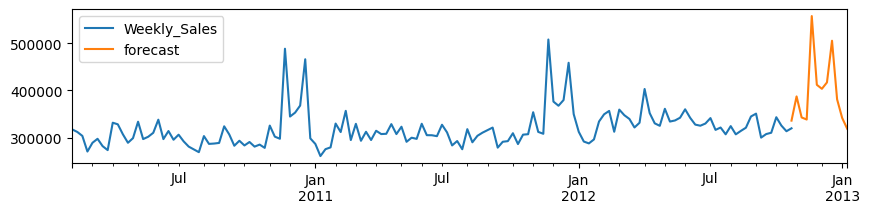

In [ ]:
future_df['forecast'] = smodel2_fit.predict(start = 142, end = 153, dynamic= True)
future_df[['Weekly_Sales', 'forecast']].plot(figsize=(10, 2))

Now creating model for  top 3 stores with lowest weekly sales

Store 20, 4, 14

For Store 20

In [ ]:
model_data=dataset.copy()
sn=20 #store number
model_data = model_data.loc[dataset['Store']==sn,['Date','Weekly_Sales']]
model_data.set_index('Date',inplace=True)
model_data.tail()

Weekly_Sales
Date                    
2012-09-28    2008350.58
2012-10-05    2246411.89
2012-10-12    2162951.36
2012-10-19    1999363.49
2012-10-26    2031650.55

In [ ]:
model_data.dtypes

Weekly_Sales    float64
dtype: object

In [ ]:
model_data.shape

(143, 1)

<Axes: xlabel='Date'>

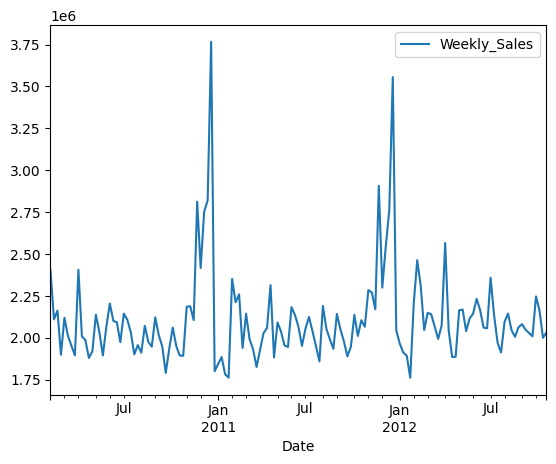

In [ ]:
model_data.plot()

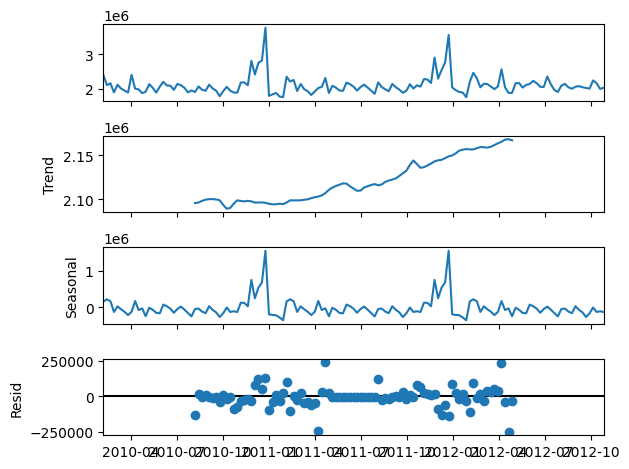

In [ ]:



result = seasonal_decompose(model_data, model='additive')
result.plot()
pyplot.show()

ADF Stationarity Test and KPSS Stationarity Test

In [ ]:
adfuller_test(model_data['Weekly_Sales'])

 H0 : It is non-stationary
 H1 : It is Stationary
ADF Test Statistic : -5.39373869285483
p-value : 3.4912952838128377e-06
Lags Used : 4
Numer of Observations Used : 138
	1%: -3.479
	5%: -2.883
	10%: -2.578
Strong evidence against Null Hypothesis. Reject Null Hypothesis


In [ ]:
kpss_test(model_data['Weekly_Sales'])

 H0 : It is stationary
 H1 : It is  non-stationary
Test Statistic: 0.052487
p-value: 0.100000
Critical values:
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216


For store 20, weekly sales timeseries ADF concludes stationary, and KPSS concludes stationary

 Checking stationarity visually

In [ ]:
data_mean=model_data['Weekly_Sales'].rolling(window=52).mean()
data_std=model_data['Weekly_Sales'].rolling(window=52).std()

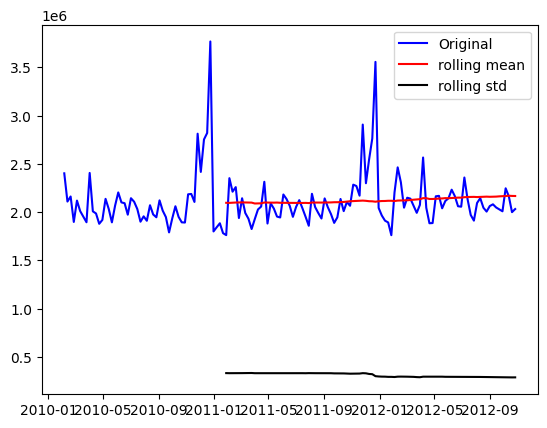

In [ ]:
plt.plot(model_data['Weekly_Sales'], color='Blue', label='Original')
plt.plot(data_mean, color='red', label='rolling mean')
plt.plot(data_std, color='black', label='rolling std')
plt.legend(loc='best')
plt.show()

Now the Timeseries is Stationary.

Manually selecting p,d,q values using charts

## Plotting ACF and PACF Plots

*   **Identification of AR Model is often done best with PACF.**
    <br><br>For an AR model, theoretical PACF shuts off  past the order of the model. The phrase shuts off  means that in theory the Partial autocorrelation are to 0 beyond that point.<br><br>
*   **Identification of MA Model is often done best with ACF rather than PACF.**
<br><br>For a MA model, theoritical PACF does not shuts off but instead tapers towards 0. The ACF  will have non-zero auto-correlations only at lags involved in the model.



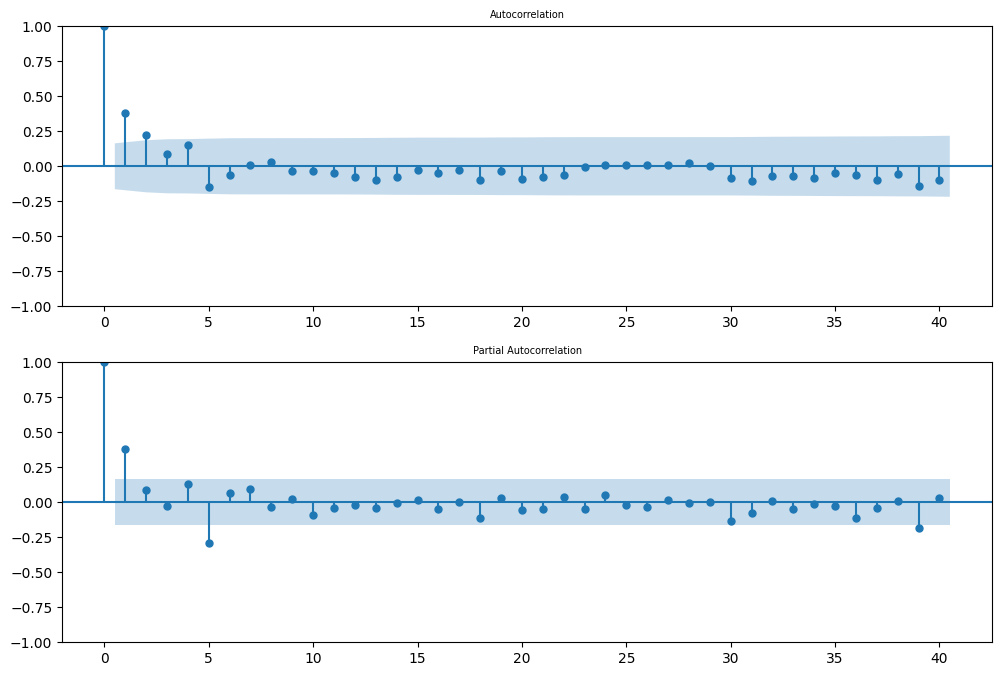

In [ ]:
fig=plt.figure(figsize=(12,8))
ax1= fig.add_subplot(211)
fig= sm.graphics.tsa.plot_acf(model_data['Weekly_Sales'], lags=40,ax=ax1)
ax2= fig.add_subplot(212)
fig= sm.graphics.tsa.plot_pacf(model_data['Weekly_Sales'], lags=40,ax=ax2)


P =  2/3/4 <br>
D = 0 <br>
Q = 1/2 <br>

Using Auto arima for Optimal p,d,q values based on  AIC Criterion

Using without stepwise

In [ ]:
arimaauto1   = auto_arima(model_data['Weekly_Sales'],stepwise =False,d=0,max_p =10, max_q=10 ,trace=True,supress_warnings=True,max_order=None, n_fits=10)

 ARIMA(0,0,0)(0,0,0)[1] intercept   : AIC=3991.763, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[1] intercept   : AIC=3977.707, Time=0.05 sec
 ARIMA(0,0,2)(0,0,0)[1] intercept   : AIC=3973.302, Time=0.06 sec
 ARIMA(0,0,3)(0,0,0)[1] intercept   : AIC=3974.530, Time=0.08 sec
 ARIMA(0,0,4)(0,0,0)[1] intercept   : AIC=3961.825, Time=0.11 sec
 ARIMA(0,0,5)(0,0,0)[1] intercept   : AIC=3961.701, Time=0.11 sec
 ARIMA(0,0,6)(0,0,0)[1] intercept   : AIC=3963.268, Time=0.17 sec
 ARIMA(0,0,7)(0,0,0)[1] intercept   : AIC=3965.385, Time=0.18 sec
 ARIMA(0,0,8)(0,0,0)[1] intercept   : AIC=3967.743, Time=0.22 sec
 ARIMA(0,0,9)(0,0,0)[1] intercept   : AIC=3969.992, Time=0.24 sec
 ARIMA(0,0,10)(0,0,0)[1] intercept   : AIC=3972.112, Time=0.33 sec
 ARIMA(1,0,0)(0,0,0)[1] intercept   : AIC=3971.424, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[1] intercept   : AIC=3972.813, Time=0.08 sec
 ARIMA(1,0,2)(0,0,0)[1] intercept   : AIC=3974.775, Time=0.10 sec
 ARIMA(1,0,3)(0,0,0)[1] intercept   : AIC=3976.743, Time=0.13 sec
 ARIMA(1,

In [ ]:
arimaauto1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  143
Model:               SARIMAX(0, 0, 5)   Log Likelihood               -1973.851
Date:                Mon, 31 Jul 2023   AIC                           3961.701
Time:                        20:51:28   BIC                           3982.441
Sample:                    02-05-2010   HQIC                          3970.129
                         - 10-26-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   2.108e+06   5.55e+04     38.001      0.000       2e+06    2.22e+06
ma.L1          0.4049      0.067      6.023      0.000       0.273       0.537
ma.L2          0.2594      0.075      3.478      0.001       0.113       0.406
ma.L3          0.0673      0.080      0.842      0.400      -0.089       0.224
ma.L4          0.3007      0.096      3.120      0.002       0.112       0.490
ma.L5         -0.1435      0.091     -1.577      0.115      -0.322       0.035
sigma2      6.372e+10      0.228   2.79e+11      0.000    6.37e+10    6.37e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               217.07
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               0.68   Skew:                             1.40
Prob(H) (two-sided):                  0.19   Kurtosis:                         8.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.22e+26. Standard errors may be unstable.
"""

Using Stepwise.

In [ ]:
arimaauto2   = auto_arima(model_data['Weekly_Sales'],d=0,trace=True,supress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=3974.854, Time=0.31 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=3991.763, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=3971.424, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=3977.707, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=4574.703, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=3972.263, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=3972.813, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=3974.255, Time=0.17 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.809 seconds


In [ ]:
arimaauto2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  143
Model:               SARIMAX(1, 0, 0)   Log Likelihood               -1982.712
Date:                Mon, 31 Jul 2023   AIC                           3971.424
Time:                        20:51:29   BIC                           3980.313
Sample:                    02-05-2010   HQIC                          3975.036
                         - 10-26-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.304e+06   1.01e+05     12.964      0.000    1.11e+06     1.5e+06
ar.L1          0.3815      0.038     10.058      0.000       0.307       0.456
sigma2      6.452e+10      0.934   6.91e+10      0.000    6.45e+10    6.45e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.19   Jarque-Bera (JB):               674.61
Prob(Q):                              0.66   Prob(JB):                         0.00
Heteroskedasticity (H):               0.67   Skew:                             1.98
Prob(H) (two-sided):                  0.17   Kurtosis:                        12.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.12e+25. Standard errors may be unstable.
"""

Now Splitting Data and Building Model

In [ ]:
l=len( model_data)
split_ind = int(l*0.8)
train = model_data.iloc[0: split_ind]
test = model_data.iloc[split_ind : l]


## ARIMA

Using Manually identified PDQ

<Axes: xlabel='Date'>

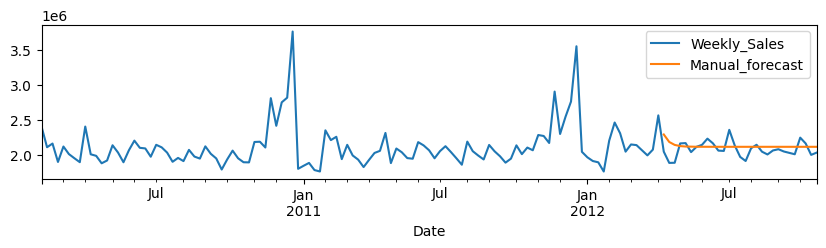

In [ ]:
model = sm.tsa.arima.ARIMA(train['Weekly_Sales'],order=(1,0,0))
model_fit =  model.fit()
model_data['Manual_forecast']=model_fit.predict(start=split_ind,end=(l-1),dynamic=True)
model_data[['Weekly_Sales','Manual_forecast']].plot(figsize=(10,2))

In [ ]:
error_cal(test['Weekly_Sales'],model_data['Manual_forecast'][split_ind:], "manual arima" )


mae - manual arima : 97959.87253255825
mape - manual arima : 0.04798640562814809
rmse - manual arima : 125459.16212937377




ARIMA is not working well.

## SARIMA

In [ ]:
sarimaauto   = auto_arima(model_data['Weekly_Sales'],d=0,D=1 ,seasonal=True,m=52,trace=True,supress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[52] intercept   : AIC=inf, Time=48.35 sec
 ARIMA(0,0,0)(0,1,0)[52] intercept   : AIC=2413.261, Time=0.16 sec
 ARIMA(1,0,0)(1,1,0)[52] intercept   : AIC=2414.925, Time=8.21 sec
 ARIMA(0,0,1)(0,1,1)[52] intercept   : AIC=2415.279, Time=3.40 sec
 ARIMA(0,0,0)(0,1,0)[52]             : AIC=2429.787, Time=0.17 sec
 ARIMA(0,0,0)(1,1,0)[52] intercept   : AIC=2412.512, Time=1.77 sec
 ARIMA(0,0,0)(2,1,0)[52] intercept   : AIC=2413.038, Time=7.73 sec
 ARIMA(0,0,0)(1,1,1)[52] intercept   : AIC=inf, Time=12.49 sec
 ARIMA(0,0,0)(0,1,1)[52] intercept   : AIC=2412.456, Time=1.70 sec
 ARIMA(0,0,0)(0,1,2)[52] intercept   : AIC=2413.032, Time=6.26 sec
 ARIMA(0,0,0)(1,1,2)[52] intercept   : AIC=inf, Time=51.20 sec
 ARIMA(1,0,0)(0,1,1)[52] intercept   : AIC=2414.875, Time=4.79 sec
 ARIMA(1,0,1)(0,1,1)[52] intercept   : AIC=2412.922, Time=9.33 sec
 ARIMA(0,0,0)(0,1,1)[52]             : AIC=2421.132, Time=5.09 sec

Best model:  ARIMA(0,0,0)(0,1,

In [ ]:
smodel1=sm.tsa.statespace.SARIMAX(train['Weekly_Sales'],order=(4,0,0),seasonal_order=(2,1,0,52))
smodel1_fit =  smodel1.fit()

In [ ]:
smodel2=sm.tsa.statespace.SARIMAX(train['Weekly_Sales'],order=(4,0,0),seasonal_order=(1,1,1,52))
smodel2_fit =  smodel2.fit()

In [ ]:
smodel3=sm.tsa.statespace.SARIMAX(train['Weekly_Sales'],order=(2,0,1),seasonal_order=(1,0,0,52))
smodel3_fit =  smodel3.fit()

In [ ]:
sm1=smodel1_fit.predict(start=split_ind,end=(l-1),dynamic=True)
sm2=smodel2_fit.predict(start=split_ind,end=(l-1),dynamic=True)
sm3=smodel3_fit.predict(start=split_ind,end=(l-1),dynamic=True)


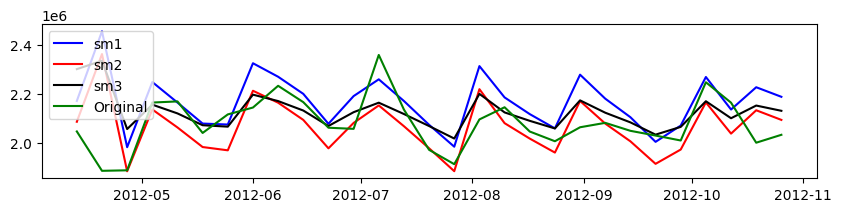

In [ ]:
fig=plt.figure(figsize=(10,2))
plt.plot(sm1, color='Blue', label='sm1')
plt.plot(sm2, color='red', label='sm2')
plt.plot(sm3, color='black', label='sm3')
plt.plot(test['Weekly_Sales'], color='Green', label='Original')
plt.legend(loc='best')
plt.show()

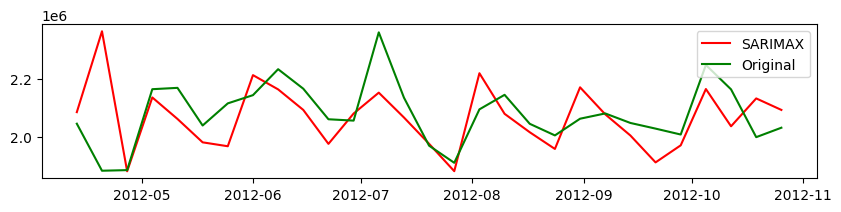

In [ ]:
fig=plt.figure(figsize=(10,2))
plt.plot(sm2, color='red', label='SARIMAX')
plt.plot(test['Weekly_Sales'], color='Green', label='Original')
plt.legend(loc='best')
plt.show()

Error Calculation.

Making  Prediction for test data.Will only be sing Sarima model

In [ ]:
error_cal(test['Weekly_Sales'],sm1, "sm1 " )#96545
error_cal(test['Weekly_Sales'],sm2, "sm2 " )#96933
error_cal(test['Weekly_Sales'],sm3, "sm3 " )


mae - sm1  : 101307.26119407562
mape - sm1  : 0.049960152058264755
rmse - sm1  : 148264.98253473095


mae - sm2  : 84831.59273396996
mape - sm2  : 0.04100533862592157
rmse - sm2  : 121991.94052585644


mae - sm3  : 86559.48646971442
mape - sm3  : 0.04254102421170664
rmse - sm3  : 124560.57527876792




sm2 is giving best result with seasonality

Forecasting

In [ ]:
main_data = dataset.loc[dataset['Store']==sn,['Date','Weekly_Sales']]
main_data=main_data.set_index('Date')

In [ ]:
main_data.head()

Weekly_Sales
Date                    
2010-02-05    2401395.47
2010-02-12    2109107.90
2010-02-19    2161549.76
2010-02-26    1898193.95
2010-03-05    2119213.72

In [ ]:
from pandas.tseries.offsets import DateOffset
future_dates=[main_data.index[-1]+ DateOffset(weeks=x)for x in range(0,12)]

In [ ]:
futuredates_df = pd.DataFrame(index=future_dates[1:],columns = ['Weekly_Sales'])

In [ ]:
futuredates_df.head()


Weekly_Sales
2012-11-02          NaN
2012-11-09          NaN
2012-11-16          NaN
2012-11-23          NaN
2012-11-30          NaN

In [ ]:
future_df=pd.concat([main_data,futuredates_df])

<Axes: >

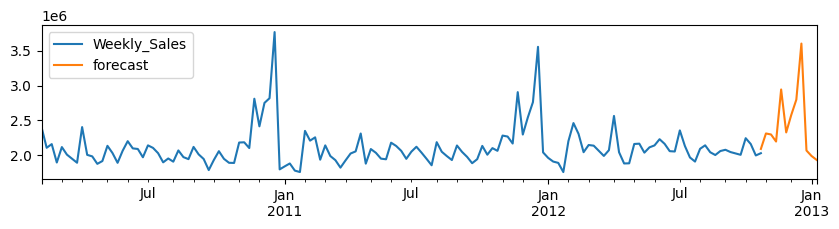

In [ ]:
future_df['forecast'] = smodel2_fit.predict(start = 142, end = 153, dynamic= True)
future_df[['Weekly_Sales', 'forecast']].plot(figsize=(10, 2))

For Store 4

In [ ]:
model_data=dataset.copy()
sn=4 #store number
model_data = model_data.loc[dataset['Store']==sn,['Date','Weekly_Sales']]
model_data.set_index('Date',inplace=True)
model_data.tail()

Weekly_Sales
Date                    
2012-09-28    2027620.23
2012-10-05    2209835.43
2012-10-12    2133026.07
2012-10-19    2097266.85
2012-10-26    2149594.46

In [ ]:
model_data.dtypes

Weekly_Sales    float64
dtype: object

In [ ]:
model_data.shape

(143, 1)

<Axes: xlabel='Date'>

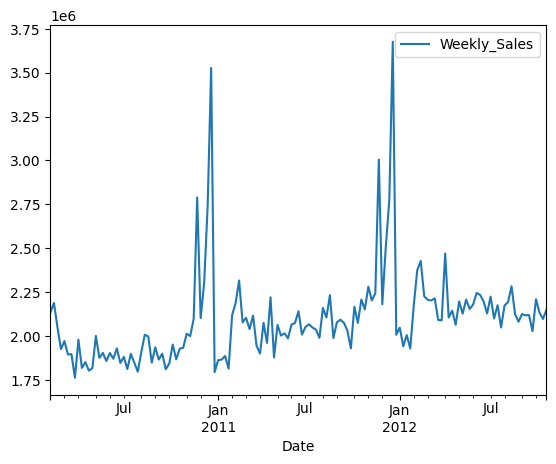

In [ ]:
model_data.plot()

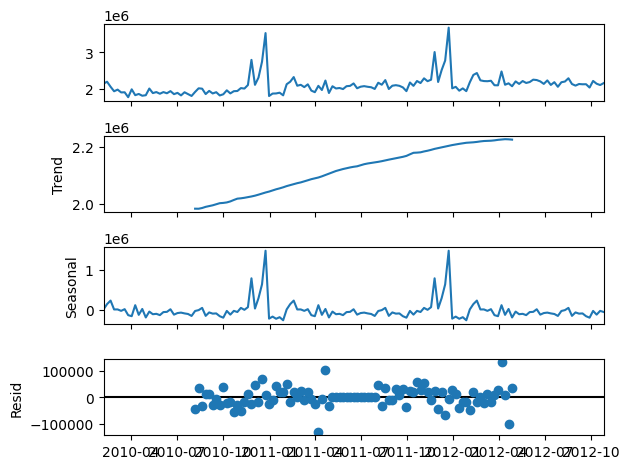

In [ ]:


result = seasonal_decompose(model_data, model='additive')
result.plot()
pyplot.show()

ADF Stationarity Test and KPSS Stationarity Test

In [ ]:
adfuller_test(model_data['Weekly_Sales'])

 H0 : It is non-stationary
 H1 : It is Stationary
ADF Test Statistic : -2.8793819840147123
p-value : 0.04779866223669836
Lags Used : 6
Numer of Observations Used : 136
	1%: -3.479
	5%: -2.883
	10%: -2.578
Strong evidence against Null Hypothesis. Reject Null Hypothesis


In [ ]:
kpss_test(model_data['Weekly_Sales'])

 H0 : It is stationary
 H1 : It is  non-stationary
Test Statistic: 0.097814
p-value: 0.100000
Critical values:
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216


For store 4, weekly sales timeseries ADF concludes stationary, and KPSS concludes stationary

 Checking stationarity visually

In [ ]:
data_mean=model_data['Weekly_Sales'].rolling(window=52).mean()
data_std=model_data['Weekly_Sales'].rolling(window=52).std()

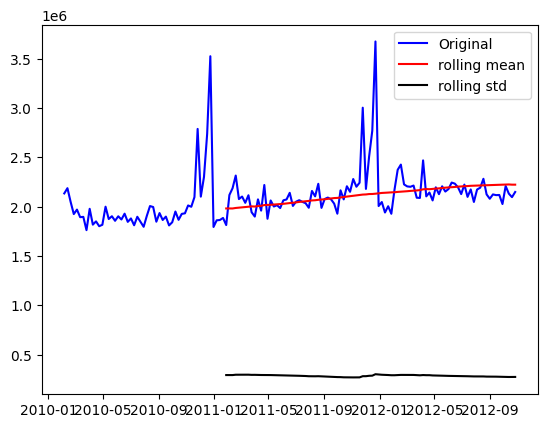

In [ ]:
plt.plot(model_data['Weekly_Sales'], color='Blue', label='Original')
plt.plot(data_mean, color='red', label='rolling mean')
plt.plot(data_std, color='black', label='rolling std')
plt.legend(loc='best')
plt.show()

Now the Timeseries is Stationary.

Manually selecting p,d,q values using charts

## Plotting ACF and PACF Plots

*   **Identification of AR Model is often done best with PACF.**
    <br><br>For an AR model, theoretical PACF shuts off  past the order of the model. The phrase shuts off  means that in theory the Partial autocorrelation are to 0 beyond that point.<br><br>
*   **Identification of MA Model is often done best with ACF rather than PACF.**
<br><br>For a MA model, theoritical PACF does not shuts off but instead tapers towards 0. The ACF  will have non-zero auto-correlations only at lags involved in the model.



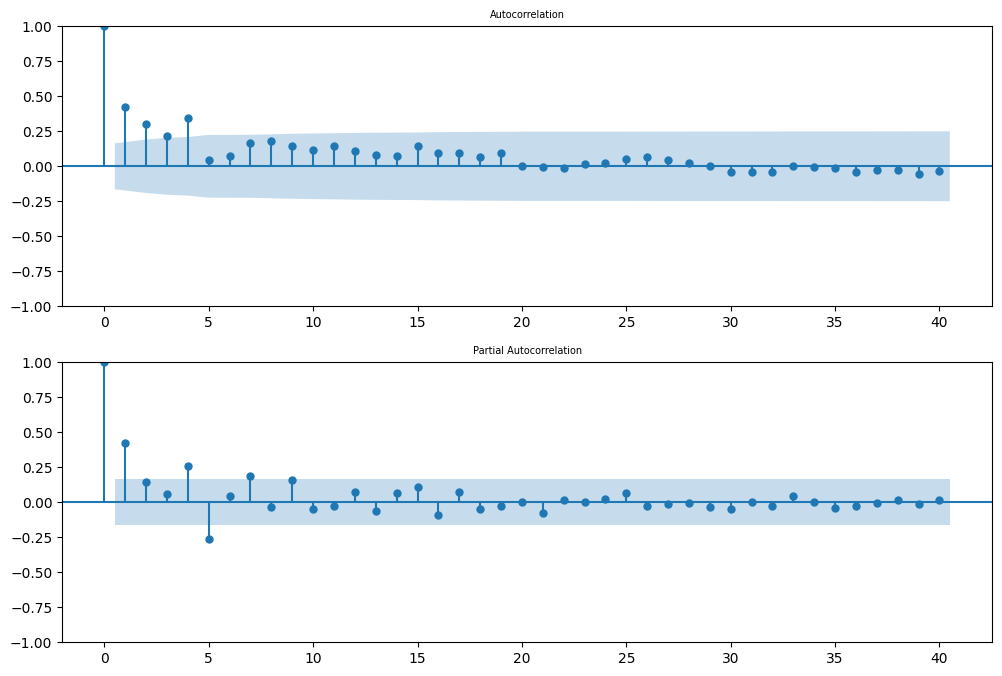

In [ ]:
fig=plt.figure(figsize=(12,8))
ax1= fig.add_subplot(211)
fig= sm.graphics.tsa.plot_acf(model_data['Weekly_Sales'], lags=40,ax=ax1)
ax2= fig.add_subplot(212)
fig= sm.graphics.tsa.plot_pacf(model_data['Weekly_Sales'], lags=40,ax=ax2)


P =  2/3 <br>
D = 0 <br>
Q = 1/2/4 <br>

Using Auto arima for Optimal p,d,q values based on  AIC Criterion

Using without stepwise

In [ ]:

arimaauto1   = auto_arima(model_data['Weekly_Sales'],stepwise =False,d=0,max_p =10, max_q=10 ,trace=True,supress_warnings=True,max_order=None, n_fits=10)

 ARIMA(0,0,0)(0,0,0)[1] intercept   : AIC=3981.527, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[1] intercept   : AIC=3965.325, Time=0.03 sec
 ARIMA(0,0,2)(0,0,0)[1] intercept   : AIC=3959.121, Time=0.04 sec
 ARIMA(0,0,3)(0,0,0)[1] intercept   : AIC=3958.806, Time=0.06 sec
 ARIMA(0,0,4)(0,0,0)[1] intercept   : AIC=3933.781, Time=0.07 sec
 ARIMA(0,0,5)(0,0,0)[1] intercept   : AIC=3934.791, Time=0.09 sec
 ARIMA(0,0,6)(0,0,0)[1] intercept   : AIC=3935.544, Time=0.10 sec
 ARIMA(0,0,7)(0,0,0)[1] intercept   : AIC=3937.399, Time=0.12 sec
 ARIMA(0,0,8)(0,0,0)[1] intercept   : AIC=3939.185, Time=0.14 sec
 ARIMA(0,0,9)(0,0,0)[1] intercept   : AIC=3940.078, Time=0.17 sec
 ARIMA(0,0,10)(0,0,0)[1] intercept   : AIC=3942.063, Time=0.21 sec
 ARIMA(1,0,0)(0,0,0)[1] intercept   : AIC=3955.431, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[1] intercept   : AIC=3955.020, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[1] intercept   : AIC=3957.654, Time=0.07 sec
 ARIMA(1,0,3)(0,0,0)[1] intercept   : AIC=3958.966, Time=0.09 sec
 ARIMA(1,

In [ ]:
arimaauto1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  143
Model:               SARIMAX(1, 0, 5)   Log Likelihood               -1958.364
Date:                Fri, 04 Aug 2023   AIC                           3932.728
Time:                        11:25:53   BIC                           3956.430
Sample:                    02-05-2010   HQIC                          3942.359
                         - 10-26-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   7.222e+05   4.09e-08   1.77e+13      0.000    7.22e+05    7.22e+05
ar.L1          0.6556      0.010     65.257      0.000       0.636       0.675
ma.L1         -0.1719      0.069     -2.494      0.013      -0.307      -0.037
ma.L2          0.0131      0.074      0.176      0.860      -0.133       0.159
ma.L3         -0.1437      0.066     -2.167      0.030      -0.274      -0.014
ma.L4          0.4375      0.068      6.464      0.000       0.305       0.570
ma.L5         -0.3423      0.070     -4.899      0.000      -0.479      -0.205
sigma2      5.103e+10   4.28e-13   1.19e+23      0.000     5.1e+10     5.1e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               186.80
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               0.88   Skew:                             1.29
Prob(H) (two-sided):                  0.65   Kurtosis:                         7.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.21e+37. Standard errors may be unstable.
"""

Using Stepwise.

In [ ]:
arimaauto2   = auto_arima(model_data['Weekly_Sales'],d=0,trace=True,supress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=3955.283, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=3981.527, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=3955.431, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=3965.325, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=4572.801, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=3957.654, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=3956.150, Time=0.06 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=3956.003, Time=0.21 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=3949.316, Time=0.16 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=3958.966, Time=0.11 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.35 sec
 ARIMA(2,0,4)(0,0,0)[0] intercept   : AIC=3938.603, Time=0.14 sec
 ARIMA(1,0,4)(0,0,0)[0] intercept   : AIC=3940.680, Time=0.14 sec
 ARIMA(3,0,4)(0,0,0)[0] intercept   : AIC=3938.017, Time=0.27 sec
 ARIMA(4,0,4)(0,0,0)[0] intercept   : 

In [ ]:
arimaauto2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  143
Model:               SARIMAX(1, 0, 5)   Log Likelihood               -1958.364
Date:                Fri, 04 Aug 2023   AIC                           3932.728
Time:                        11:27:02   BIC                           3956.430
Sample:                    02-05-2010   HQIC                          3942.359
                         - 10-26-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   7.222e+05   4.09e-08   1.77e+13      0.000    7.22e+05    7.22e+05
ar.L1          0.6556      0.010     65.257      0.000       0.636       0.675
ma.L1         -0.1719      0.069     -2.494      0.013      -0.307      -0.037
ma.L2          0.0131      0.074      0.176      0.860      -0.133       0.159
ma.L3         -0.1437      0.066     -2.167      0.030      -0.274      -0.014
ma.L4          0.4375      0.068      6.464      0.000       0.305       0.570
ma.L5         -0.3423      0.070     -4.899      0.000      -0.479      -0.205
sigma2      5.103e+10   4.28e-13   1.19e+23      0.000     5.1e+10     5.1e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               186.80
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               0.88   Skew:                             1.29
Prob(H) (two-sided):                  0.65   Kurtosis:                         7.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.21e+37. Standard errors may be unstable.
"""

Now Splitting Data and Building Model

In [ ]:
l=len( model_data)
split_ind = int(l*0.8)
train = model_data.iloc[0: split_ind]
test = model_data.iloc[split_ind : l]


## ARIMA

Using Manually identified PDQ

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)


<Axes: xlabel='Date'>

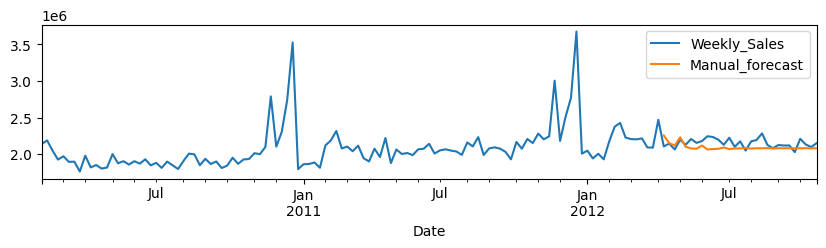

In [ ]:
model = sm.tsa.arima.ARIMA(train['Weekly_Sales'],order=(5,0,0))
model_fit =  model.fit()
model_data['Manual_forecast']=model_fit.predict(start=split_ind,end=(l-1),dynamic=True)
model_data[['Weekly_Sales','Manual_forecast']].plot(figsize=(10,2))

In [ ]:
error_cal(test['Weekly_Sales'],model_data['Manual_forecast'][split_ind:], "manual arima" )

mae - manual arima : 77797.49235819791
mape - manual arima : 0.03567215589519433
rmse - manual arima : 95336.36630050512




ARIMA is not working well.

## SARIMA

In [ ]:
sarimaauto   = auto_arima(model_data['Weekly_Sales'],d=0,D=1,max_p =3, max_q=3,stepwise=False,seasonal=True,m=52,trace=True,supress_warnings=True)

 ARIMA(0,0,0)(0,1,0)[52] intercept   : AIC=2335.756, Time=0.48 sec
 ARIMA(0,0,0)(0,1,1)[52] intercept   : AIC=2334.684, Time=8.13 sec
 ARIMA(0,0,0)(0,1,2)[52] intercept   : AIC=2330.935, Time=20.84 sec
 ARIMA(0,0,0)(1,1,0)[52] intercept   : AIC=2335.169, Time=3.52 sec
 ARIMA(0,0,0)(1,1,1)[52] intercept   : AIC=2332.267, Time=19.51 sec
 ARIMA(0,0,0)(1,1,2)[52] intercept   : AIC=inf, Time=58.51 sec
 ARIMA(0,0,0)(2,1,0)[52] intercept   : AIC=2330.982, Time=8.58 sec
 ARIMA(0,0,0)(2,1,1)[52] intercept   : AIC=inf, Time=51.58 sec
 ARIMA(0,0,0)(2,1,2)[52] intercept   : AIC=inf, Time=70.41 sec
 ARIMA(0,0,1)(0,1,0)[52] intercept   : AIC=2336.738, Time=0.51 sec
 ARIMA(0,0,1)(0,1,1)[52] intercept   : AIC=2334.787, Time=4.40 sec
 ARIMA(0,0,1)(0,1,2)[52] intercept   : AIC=2329.236, Time=13.09 sec
 ARIMA(0,0,1)(1,1,0)[52] intercept   : AIC=2335.465, Time=4.65 sec
 ARIMA(0,0,1)(1,1,1)[52] intercept   : AIC=2330.655, Time=13.88 sec
 ARIMA(0,0,1)(1,1,2)[52] intercept   : AIC=inf, Time=64.46 sec
 ARIMA(

In [ ]:
smodel1=sm.tsa.statespace.SARIMAX(train['Weekly_Sales'],order=(5,0,0),seasonal_order=(2,0,1,52))
smodel1_fit =  smodel1.fit()

In [ ]:
smodel2=sm.tsa.statespace.SARIMAX(train['Weekly_Sales'],order=(3,0,1),seasonal_order=(3,1,1,52))
smodel2_fit =  smodel2.fit()

In [ ]:
smodel3=sm.tsa.statespace.SARIMAX(train['Weekly_Sales'],order=(3,0,1),seasonal_order=(4,1,1,52))
smodel3_fit =  smodel3.fit()

In [ ]:
sm1=smodel1_fit.predict(start=split_ind,end=(l-1),dynamic=True)
sm2=smodel2_fit.predict(start=split_ind,end=(l-1),dynamic=True)
sm3=smodel3_fit.predict(start=split_ind,end=(l-1),dynamic=True)


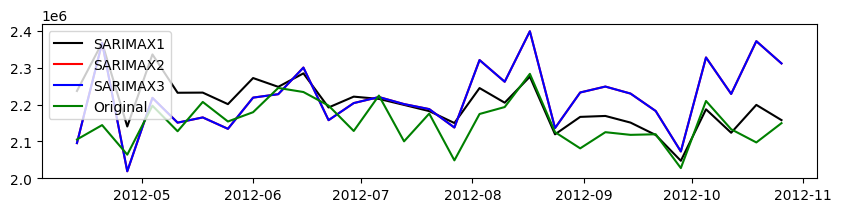

In [ ]:
fig=plt.figure(figsize=(10,2))
plt.plot(sm1, color='black', label='SARIMAX1')
plt.plot(sm2, color='red', label='SARIMAX2')
plt.plot(sm3, color='blue', label='SARIMAX3')
plt.plot(test['Weekly_Sales'], color='Green', label='Original')
plt.legend(loc='best')
plt.show()

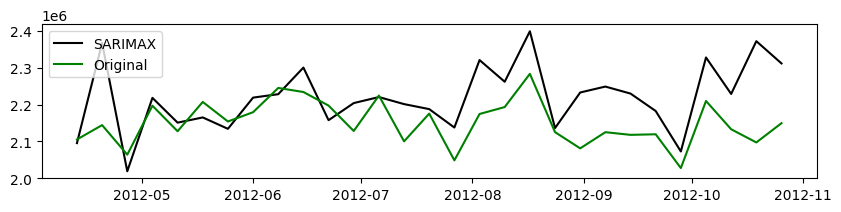

In [ ]:
fig=plt.figure(figsize=(10,2))
plt.plot(sm2, color='black', label='SARIMAX')
plt.plot(test['Weekly_Sales'], color='Green', label='Original')
plt.legend(loc='best')
plt.show()

Error Calculation.

Making  Prediction for test data.Will only be sing Sarima model

In [ ]:
error_cal(test['Weekly_Sales'],sm1, "sm1 " )
error_cal(test['Weekly_Sales'],sm2, "sm2 " )
error_cal(test['Weekly_Sales'],sm3, "sm3 " )


mae - sm1  : 56267.09533755707
mape - sm1  : 0.026397992603907686
rmse - sm1  : 77335.16942949085


mae - sm2  : 79954.23795395432
mape - sm2  : 0.03735975283543137
rmse - sm2  : 103180.99564001475


mae - sm3  : 79957.80797580896
mape - sm3  : 0.037361425284759234
rmse - sm3  : 103188.33789345127




sm1 gave best results

Forecasting

In [ ]:
main_data = dataset.loc[dataset['Store']==sn,['Date','Weekly_Sales']]
main_data=main_data.set_index('Date')

In [ ]:
main_data.head()

Weekly_Sales
Date                    
2010-02-05    2135143.87
2010-02-12    2188307.39
2010-02-19    2049860.26
2010-02-26    1925728.84
2010-03-05    1971057.44

In [ ]:

future_dates=[main_data.index[-1]+ DateOffset(weeks=x)for x in range(0,12)]

In [ ]:
futuredates_df = pd.DataFrame(index=future_dates[1:],columns = ['Weekly_Sales'])

In [ ]:
futuredates_df.head()


Weekly_Sales
2012-11-02          NaN
2012-11-09          NaN
2012-11-16          NaN
2012-11-23          NaN
2012-11-30          NaN

In [ ]:
future_df=pd.concat([main_data,futuredates_df])

<Axes: >

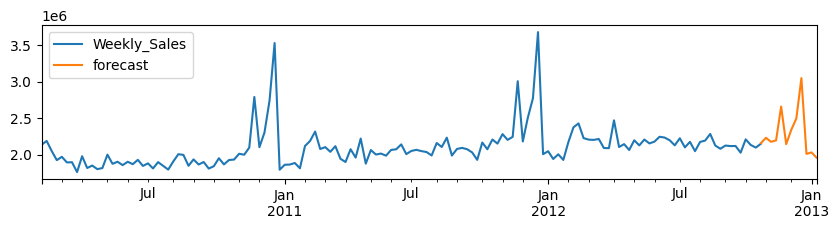

In [ ]:
future_df['forecast'] = smodel1_fit.predict(start = 142, end = 153, dynamic= True)
future_df[['Weekly_Sales', 'forecast']].plot(figsize=(10, 2))

For Store 14

In [ ]:
model_data=dataset.copy()
sn=14 #store number
model_data = model_data.loc[dataset['Store']==sn,['Date','Weekly_Sales']]
model_data.set_index('Date',inplace=True)
model_data.tail()

Weekly_Sales
Date                    
2012-09-28    1522512.20
2012-10-05    1687592.16
2012-10-12    1639585.61
2012-10-19    1590274.72
2012-10-26    1704357.62

In [ ]:
model_data.dtypes

Weekly_Sales    float64
dtype: object

In [ ]:
model_data.shape

(143, 1)

<Axes: xlabel='Date'>

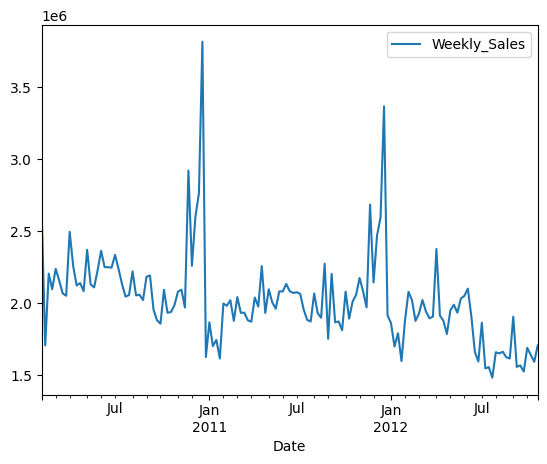

In [ ]:
model_data.plot()

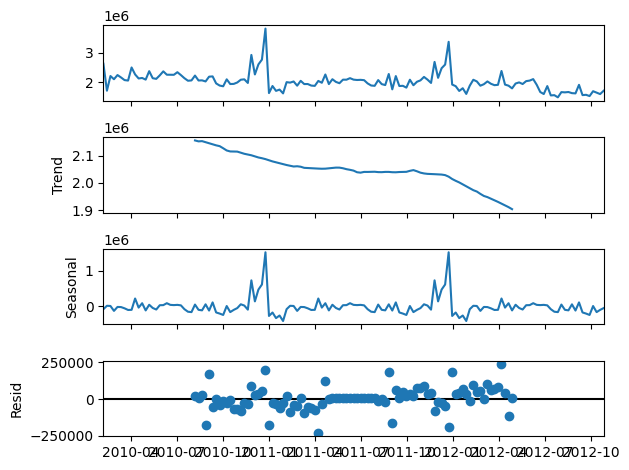

In [ ]:

from matplotlib import pyplot
result = seasonal_decompose(model_data, model='additive')
result.plot()
pyplot.show()

ADF Stationarity Test and KPSS Stationarity Test

In [ ]:
adfuller_test(model_data['Weekly_Sales'])

 H0 : It is non-stationary
 H1 : It is Stationary
ADF Test Statistic : -2.7368866106752
p-value : 0.06786986708375098
Lags Used : 6
Numer of Observations Used : 136
	1%: -3.479
	5%: -2.883
	10%: -2.578
Weak evidence against Null Hypothesis. Accept Null Hypothesis


In [ ]:
kpss_test(model_data['Weekly_Sales'])

 H0 : It is stationary
 H1 : It is  non-stationary
Test Statistic: 0.100611
p-value: 0.100000
Critical values:
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216


For store 14, weekly sales timeseries ADF concludes stationary, and KPSS concludes stationary

 Checking stationarity visually

In [ ]:
data_mean=model_data['Weekly_Sales'].rolling(window=36).mean()
data_std=model_data['Weekly_Sales'].rolling(window=36).std()

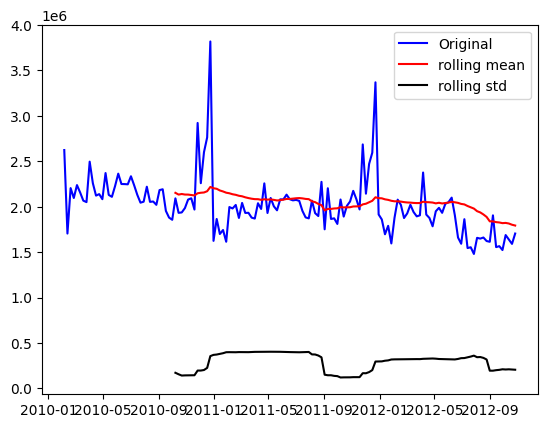

In [ ]:
plt.plot(model_data['Weekly_Sales'], color='Blue', label='Original')
plt.plot(data_mean, color='red', label='rolling mean')
plt.plot(data_std, color='black', label='rolling std')
plt.legend(loc='best')
plt.show()

In [ ]:
model_data['rolling_mean_data']= model_data['Weekly_Sales']-model_data['Weekly_Sales'].rolling(window=36).mean()

<Axes: xlabel='Date'>

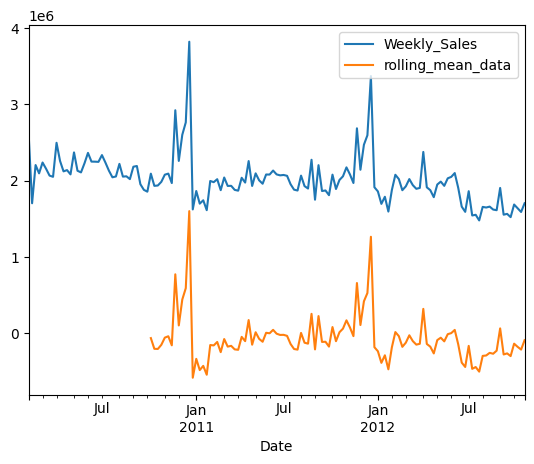

In [ ]:
model_data.plot()

In [ ]:
data_mean=model_data['rolling_mean_data'].rolling(window=52).mean()
data_std=model_data['rolling_mean_data'].rolling(window=52).std()

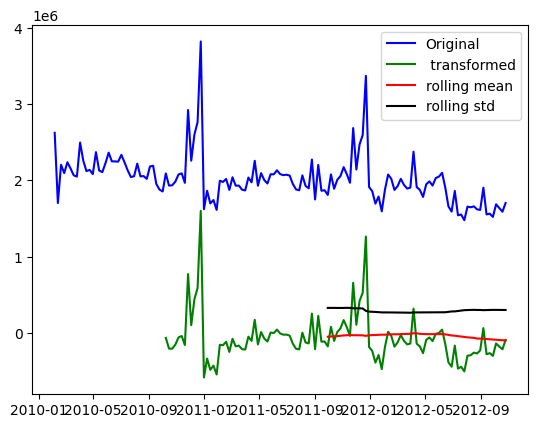

In [ ]:
plt.plot(model_data['Weekly_Sales'], color='Blue', label='Original')
plt.plot(model_data['rolling_mean_data'], color='Green', label=' transformed')
plt.plot(data_mean, color='red', label='rolling mean')
plt.plot(data_std, color='black', label='rolling std')
plt.legend(loc='best')
plt.show()

In [ ]:
adfuller_test(model_data['rolling_mean_data'].dropna())

 H0 : It is non-stationary
 H1 : It is Stationary
ADF Test Statistic : -4.665028119222441
p-value : 9.78475176970742e-05
Lags Used : 4
Numer of Observations Used : 103
	1%: -3.495
	5%: -2.890
	10%: -2.582
Strong evidence against Null Hypothesis. Reject Null Hypothesis


In [ ]:
kpss_test(model_data['rolling_mean_data'].dropna())

 H0 : It is stationary
 H1 : It is  non-stationary
Test Statistic: 0.092514
p-value: 0.100000
Critical values:
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216


Now the Timeseries is Stationary.

Manually selecting p,d,q values using charts

## Plotting ACF and PACF Plots

*   **Identification of AR Model is often done best with PACF.**
    <br><br>For an AR model, theoretical PACF shuts off  past the order of the model. The phrase shuts off  means that in theory the Partial autocorrelation are to 0 beyond that point.<br><br>
*   **Identification of MA Model is often done best with ACF rather than PACF.**
<br><br>For a MA model, theoritical PACF does not shuts off but instead tapers towards 0. The ACF  will have non-zero auto-correlations only at lags involved in the model.



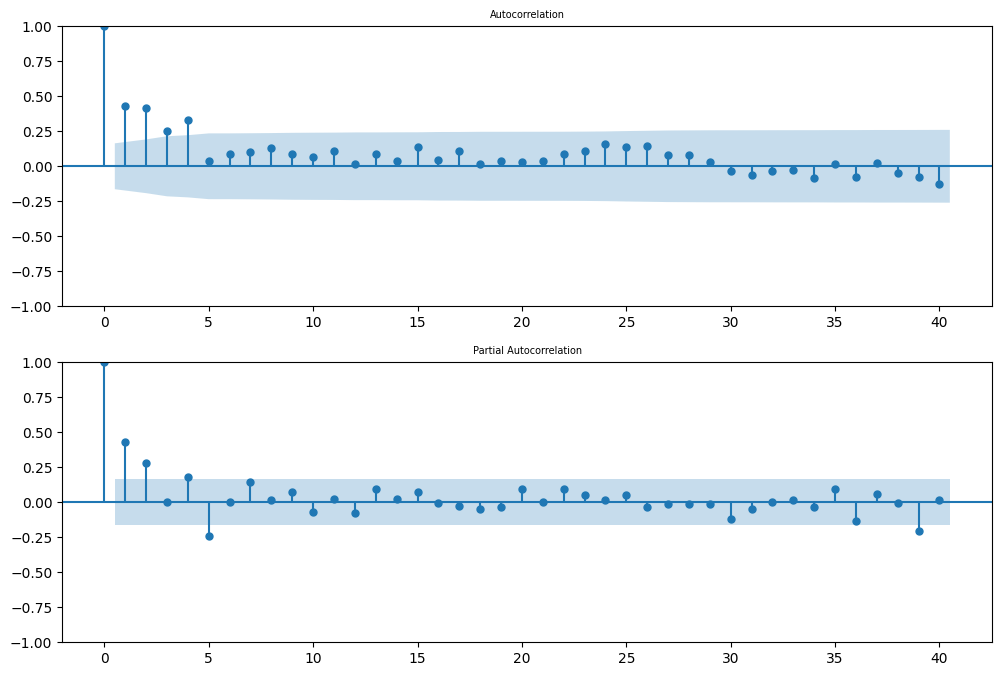

In [ ]:
fig=plt.figure(figsize=(12,8))
ax1= fig.add_subplot(211)
#fig= sm.graphics.tsa.plot_acf(model_data['rolling_mean_data'].dropna(), lags=40,ax=ax1)
#ax2= fig.add_subplot(212)
#fig= sm.graphics.tsa.plot_pacf(model_data['rolling_mean_data'].dropna(), lags=40,ax=ax2)
fig= sm.graphics.tsa.plot_acf(model_data['Weekly_Sales'].dropna(), lags=40,ax=ax1)
ax2= fig.add_subplot(212)
fig= sm.graphics.tsa.plot_pacf(model_data['Weekly_Sales'].dropna(), lags=40,ax=ax2)


P =  3/4 <br>
D = 0 <br>
Q = 1/2/5 <br>

Using Auto arima for Optimal p,d,q values based on  AIC Criterion

Using without stepwise

In [ ]:

arimaauto1   = auto_arima(model_data['Weekly_Sales'],stepwise =False,d=0,max_p =10, max_q=10 ,trace=True,supress_warnings=True,max_order=None, n_fits=10)

 ARIMA(0,0,0)(0,0,0)[1] intercept   : AIC=4031.991, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[1] intercept   : AIC=4016.922, Time=0.05 sec
 ARIMA(0,0,2)(0,0,0)[1] intercept   : AIC=4004.797, Time=0.06 sec
 ARIMA(0,0,3)(0,0,0)[1] intercept   : AIC=4006.744, Time=0.08 sec
 ARIMA(0,0,4)(0,0,0)[1] intercept   : AIC=3983.200, Time=0.11 sec
 ARIMA(0,0,5)(0,0,0)[1] intercept   : AIC=3985.117, Time=0.13 sec
 ARIMA(0,0,6)(0,0,0)[1] intercept   : AIC=3987.439, Time=0.19 sec
 ARIMA(0,0,7)(0,0,0)[1] intercept   : AIC=3989.574, Time=0.16 sec
 ARIMA(0,0,8)(0,0,0)[1] intercept   : AIC=3990.814, Time=0.23 sec
 ARIMA(0,0,9)(0,0,0)[1] intercept   : AIC=3993.568, Time=0.25 sec
 ARIMA(0,0,10)(0,0,0)[1] intercept   : AIC=3995.611, Time=0.29 sec
 ARIMA(1,0,0)(0,0,0)[1] intercept   : AIC=4003.723, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[1] intercept   : AIC=3998.952, Time=0.07 sec
 ARIMA(1,0,2)(0,0,0)[1] intercept   : AIC=3998.648, Time=0.10 sec
 ARIMA(1,0,3)(0,0,0)[1] intercept   : AIC=3999.109, Time=0.13 sec
 ARIMA(1,

In [ ]:
arimaauto1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  143
Model:               SARIMAX(0, 0, 4)   Log Likelihood               -1985.600
Date:                Mon, 07 Aug 2023   AIC                           3983.200
Time:                        17:26:11   BIC                           4000.977
Sample:                    02-05-2010   HQIC                          3990.423
                         - 10-26-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   2.003e+06   6.77e+04     29.576      0.000    1.87e+06    2.14e+06
ma.L1          0.3809      0.069      5.545      0.000       0.246       0.516
ma.L2          0.3828      0.094      4.087      0.000       0.199       0.566
ma.L3          0.2162      0.096      2.245      0.025       0.027       0.405
ma.L4          0.4444      0.067      6.594      0.000       0.312       0.576
sigma2      7.876e+10      0.205   3.84e+11      0.000    7.88e+10    7.88e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):               145.67
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):               0.56   Skew:                             0.73
Prob(H) (two-sided):                  0.05   Kurtosis:                         7.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.56e+34. Standard errors may be unstable.
"""

Using Stepwise.

In [ ]:
arimaauto2   = auto_arima(model_data['Weekly_Sales'],d=0,trace=True,supress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=3994.424, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=4031.991, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=4003.723, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=4016.922, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=4563.741, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=3998.648, Time=0.12 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=3996.122, Time=0.14 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=3995.640, Time=0.26 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=3992.920, Time=0.25 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=3999.109, Time=0.17 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=3991.275, Time=0.41 sec
 ARIMA(4,0,3)(0,0,0)[0] intercept   : AIC=3991.573, Time=0.63 sec
 ARIMA(3,0,4)(0,0,0)[0] intercept   : AIC=3990.936, Time=0.34 sec
 ARIMA(2,0,4)(0,0,0)[0] intercept   : AIC=3989.039, Time=0.28 sec
 ARIMA(1,0,4)(0,0,0)[0] intercept

In [ ]:
arimaauto2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  143
Model:               SARIMAX(0, 0, 4)   Log Likelihood               -1985.600
Date:                Mon, 07 Aug 2023   AIC                           3983.200
Time:                        17:26:15   BIC                           4000.977
Sample:                    02-05-2010   HQIC                          3990.423
                         - 10-26-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   2.003e+06   6.77e+04     29.576      0.000    1.87e+06    2.14e+06
ma.L1          0.3809      0.069      5.545      0.000       0.246       0.516
ma.L2          0.3828      0.094      4.087      0.000       0.199       0.566
ma.L3          0.2162      0.096      2.245      0.025       0.027       0.405
ma.L4          0.4444      0.067      6.594      0.000       0.312       0.576
sigma2      7.876e+10      0.205   3.84e+11      0.000    7.88e+10    7.88e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):               145.67
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):               0.56   Skew:                             0.73
Prob(H) (two-sided):                  0.05   Kurtosis:                         7.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.56e+34. Standard errors may be unstable.
"""

Now Splitting Data and Building Model

In [ ]:
l=len( model_data)
split_ind = int(l*0.8)
train = model_data.iloc[0: split_ind]
test = model_data.iloc[split_ind : l]


## ARIMA

Using Manually identified PDQ

<Axes: xlabel='Date'>

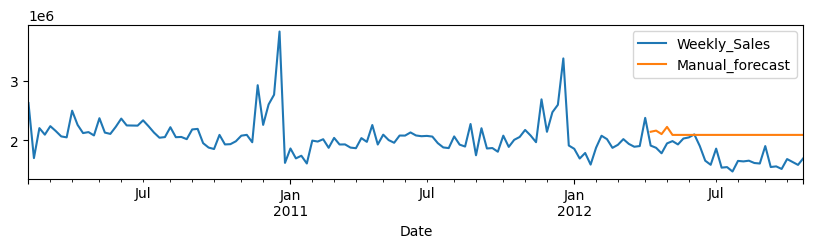

In [ ]:
model = sm.tsa.arima.ARIMA(train['Weekly_Sales'],order=(0,0,4))
model_fit =  model.fit()
model_data['Manual_forecast']=model_fit.predict(start=split_ind,end=(l-1),dynamic=True)
model_data[['Weekly_Sales','Manual_forecast']].plot(figsize=(10,2))

In [ ]:
error_cal(test['Weekly_Sales'],model_data['Manual_forecast'][split_ind:], "Manual Forecast1 " )

mae - Manual Forecast1  : 356805.3416208594
mape - Manual Forecast1  : 0.21646151076178563
rmse - Manual Forecast1  : 396174.0548942365




ARIMA is not working well.

In [ ]:
sarimaauto   = auto_arima(model_data['Weekly_Sales'],d=0,D=0,max_p =4,max_P=2, max_q=4,max_Q=2,stepwise=False,seasonal=True,m=52,trace=True,supress_warnings=True, max_order=None, maxiter=100 )

 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=4031.991, Time=0.12 sec
 ARIMA(0,0,0)(0,0,1)[52] intercept   : AIC=4005.338, Time=2.64 sec
 ARIMA(0,0,0)(0,0,2)[52] intercept   : AIC=4003.683, Time=8.14 sec
 ARIMA(0,0,0)(1,0,0)[52] intercept   : AIC=4033.603, Time=0.84 sec
 ARIMA(0,0,0)(1,0,1)[52] intercept   : AIC=4007.333, Time=2.80 sec
 ARIMA(0,0,0)(1,0,2)[52] intercept   : AIC=4005.682, Time=7.06 sec
 ARIMA(0,0,0)(2,0,0)[52] intercept   : AIC=inf, Time=5.31 sec
 ARIMA(0,0,0)(2,0,1)[52] intercept   : AIC=inf, Time=40.51 sec
 ARIMA(0,0,0)(2,0,2)[52] intercept   : AIC=inf, Time=28.20 sec
 ARIMA(0,0,1)(0,0,0)[52] intercept   : AIC=4016.922, Time=0.05 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=3993.288, Time=0.76 sec
 ARIMA(0,0,1)(0,0,2)[52] intercept   : AIC=3992.001, Time=4.33 sec
 ARIMA(0,0,1)(1,0,0)[52] intercept   : AIC=4018.067, Time=1.44 sec
 ARIMA(0,0,1)(1,0,1)[52] intercept   : AIC=3995.221, Time=1.70 sec
 ARIMA(0,0,1)(1,0,2)[52] intercept   : AIC=3993.973, Time=8.25 sec
 ARIMA(0

In [ ]:
sarimaauto   = auto_arima(model_data['Weekly_Sales'],d=0,D=1,seasonal=True,m=52,trace=True,supress_warnings=True)#3953

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[52] intercept   : AIC=inf, Time=50.38 sec
 ARIMA(0,0,0)(0,1,0)[52] intercept   : AIC=2474.352, Time=0.16 sec
 ARIMA(1,0,0)(1,1,0)[52] intercept   : AIC=2482.001, Time=3.36 sec
 ARIMA(0,0,1)(0,1,1)[52] intercept   : AIC=2478.879, Time=4.46 sec
 ARIMA(0,0,0)(0,1,0)[52]             : AIC=2526.768, Time=0.13 sec
 ARIMA(0,0,0)(1,1,0)[52] intercept   : AIC=2476.273, Time=1.64 sec
 ARIMA(0,0,0)(0,1,1)[52] intercept   : AIC=2476.281, Time=1.37 sec
 ARIMA(0,0,0)(1,1,1)[52] intercept   : AIC=2478.230, Time=4.04 sec
 ARIMA(1,0,0)(0,1,0)[52] intercept   : AIC=2481.471, Time=0.39 sec
 ARIMA(0,0,1)(0,1,0)[52] intercept   : AIC=2476.890, Time=0.47 sec
 ARIMA(1,0,1)(0,1,0)[52] intercept   : AIC=2483.451, Time=0.93 sec

Best model:  ARIMA(0,0,0)(0,1,0)[52] intercept
Total fit time: 67.376 seconds


## SARIMA

In [ ]:
smodel1=sm.tsa.statespace.SARIMAX(train['Weekly_Sales'],order=(0,0,0),seasonal_order=(0,1,0,52))
smodel1_fit =  smodel1.fit()

In [ ]:
smodel2=sm.tsa.statespace.SARIMAX(train['Weekly_Sales'],order=(1,0,4),seasonal_order=(0,1,0,52))
smodel2_fit =  smodel2.fit()

In [ ]:
smodel3=sm.tsa.statespace.SARIMAX(train['Weekly_Sales'],order=(5,0,2),seasonal_order=(1,0,0,52))
smodel3_fit =  smodel3.fit()

In [ ]:
sm1=smodel1_fit.predict(start=split_ind,end=(l-1),dynamic=True)
sm2=smodel2_fit.predict(start=split_ind,end=(l-1),dynamic=True)
sm3=smodel3_fit.predict(start=split_ind,end=(l-1),dynamic=True)


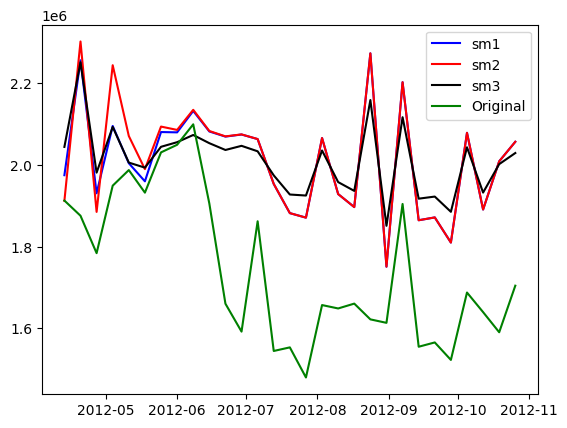

In [ ]:
plt.plot(sm1, color='Blue', label='sm1')
plt.plot(sm2, color='red', label='sm2')
plt.plot(sm3, color='black', label='sm3')
plt.plot(test['Weekly_Sales'], color='Green', label='Original')
plt.legend(loc='best')
plt.show()

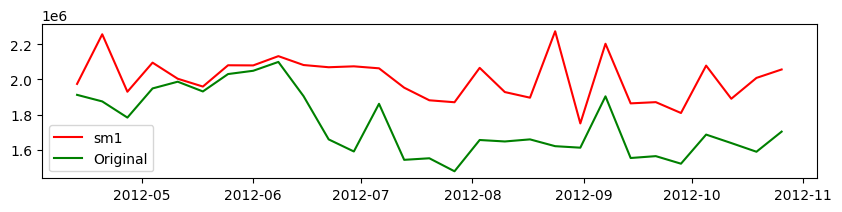

In [ ]:
fig=plt.figure(figsize=(10,2))
plt.plot(sm1, color='red', label='sm1')
plt.plot(test['Weekly_Sales'], color='Green', label='Original')
plt.legend(loc='best')
plt.show()

Error Calculation.

Making  Prediction for test data.Will only be sing Sarima model

In [ ]:
error_cal(test['Weekly_Sales'],sm1, "sm1 " )
error_cal(test['Weekly_Sales'],sm2, "sm2 " )
error_cal(test['Weekly_Sales'],sm3, "sm3 " )


mae - sm1  : 262857.96586206893
mape - sm1  : 0.15875779325032424
rmse - sm1  : 306299.3420855323


mae - sm2  : 270059.2922125134
mape - sm2  : 0.16235630947884291
rmse - sm2  : 311890.7651745702


mae - sm3  : 268788.76840451884
mape - sm3  : 0.16314496166705234
rmse - sm3  : 306879.3287756737




sm2 gave best result

Forecasting

In [ ]:
main_data = dataset.loc[dataset['Store']==sn,['Date','Weekly_Sales']]
main_data=main_data.set_index('Date')

In [ ]:
main_data.head()

Weekly_Sales
Date                    
2010-02-05    2623469.95
2010-02-12    1704218.84
2010-02-19    2204556.70
2010-02-26    2095591.63
2010-03-05    2237544.75

In [ ]:

future_dates=[main_data.index[-1]+ DateOffset(weeks=x)for x in range(0,12)]

In [ ]:
futuredates_df = pd.DataFrame(index=future_dates[1:],columns = ['Weekly_Sales'])

In [ ]:
futuredates_df.head()


Weekly_Sales
2012-11-02          NaN
2012-11-09          NaN
2012-11-16          NaN
2012-11-23          NaN
2012-11-30          NaN

In [ ]:
future_df=pd.concat([main_data,futuredates_df])

<Axes: >

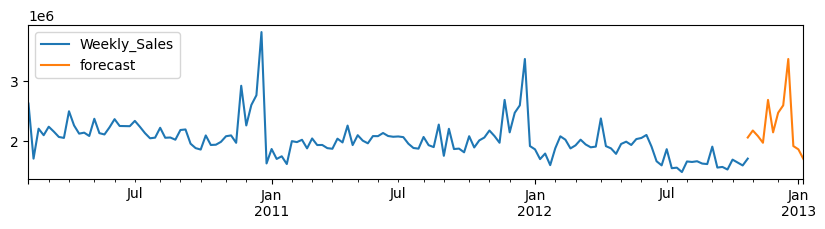

In [ ]:
future_df['forecast'] = smodel1_fit.predict(start = 142, end = 153, dynamic= True)
future_df[['Weekly_Sales', 'forecast']].plot(figsize=(10, 2))